# Alignment Neuroendocrine 
in vitro=

Hor_2020_iPNECs: Efficient generation and transcriptomic profiling of human iPSC-derived pulmonary neuroendocrine cells.

Conchola_2023: PNEC from primary human BTOs (iPNECs).

Lee_2023: PNEC from A single-cell atlas of in vitro multiculture systems.

Dayton_lab.

in vivo=

Conchola_2023:

Travaglini_2020:

Basil_2023:

## Imports

In [21]:
import scvelo as scv
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import os, tqdm
import harmonypy as hm
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib_venn import venn3
import csv
from gtfparse import read_gtf
import hdf5plugin
import seaborn as sns
import seaborn.objects as so
import scanpy.external as sce
from scipy.sparse import coo_matrix
from bioinfokit import analys, visuz
from sanbomics.plots import volcano
from scipy.cluster import hierarchy
from adjustText import adjust_text
import leidenalg
import gseapy as gp
from gseapy import barplot, dotplot
import decoupler
from scipy import io
import tempfile
import celltypist
from celltypist import models
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker
import scBalance.scbalance_IO as ss
import scBalance as sb
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import upsetplot

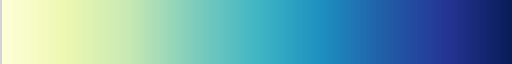

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the 'lightgrey' color as an RGBA tuple with values in the range 0-1
lightgrey_rgba = (0.83, 0.83, 0.83, 1.0)  # RGB values for lightgrey with alpha=1.0
# Get the 'YlGnBu' colormap
YlGnBu_cmap = plt.cm.get_cmap('YlGnBu')
# Define the number of steps for interpolation
num_steps = 256
# Define the range for values where lightgrey is used
lightgrey_range = 0.0
# Interpolate between light grey and blue for values from 0 to lightgrey_range
interpolated_colors_below = [lightgrey_rgba] + [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * lightgrey_range))]
# Interpolate between light grey and green for values from lightgrey_range to 1
interpolated_colors_above = [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * (1 - lightgrey_range)))]
# Combine the two sets of colors
interpolated_colors = interpolated_colors_below + interpolated_colors_above
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_YlGnBu', interpolated_colors)
# Now you can use this custom colormap in your plots
cmap

## Figure Settings

In [23]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

figfolder='./figures/'
markersfolder='./data/markers/'

# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

## Inspect matrixes AnnData

In [36]:
import numpy as np
from scipy.sparse import issparse

def matrix_summary(adata):
    """
    Prints min, max, and mean for expression matrix, counts layer, raw matrix,
    and scaled layer of an AnnData object.

    Parameters:
        adata: AnnData
    """

    # Helper function to compute min, max, mean
    def summary(matrix, name):
        if issparse(matrix):
            matrix = matrix.toarray()
        flat = matrix.flatten()
        mean_value = flat.mean()
        print(f"{name}: min={flat.min()}, max={flat.max()}, mean={mean_value}")

    # Expression matrix
    summary(adata.X, "Expression matrix (X)")

    # Counts layer
    if 'counts' in adata.layers:
        summary(adata.layers['counts'], "Counts layer matrix (layers['counts'])")
    else:
        print("Counts layer not found in adata.layers.")

    # Raw matrix
    if adata.raw is not None:
        summary(adata.raw.X, "Raw matrix (raw.X)")
    else:
        print("Raw matrix not found in adata.raw.")

    # Scaled layer
    if 'scaled' in adata.layers:
        summary(adata.layers['scaled'], "Scaled layer matrix (layers['scaled'])")
    else:
        print("Scaled layer not found in adata.layers.")

# PCA AND EMBEDDINGS WITHOUT INTEGRATION

In [26]:
#Load adata before harmony integration
adata=sc.read_h5ad('./data/Merged_Neuroendocrine_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 2838 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [27]:
matrix_summary(adata)

Expression matrix (X): min=-6.235107326478655, max=8.199231881195244, mean=9.144117855883753e-16

Counts layer matrix (layers['counts']): min=0.0, max=17590.0, mean=0.33038913503957706

Raw matrix (raw.X): min=0.0, max=8.921710102379791, mean=0.11487480372695755

Scaled layer matrix (layers['scaled']): min=-11.434715632360767, max=52.91631607896743, mean=-4.879744705446661e-17

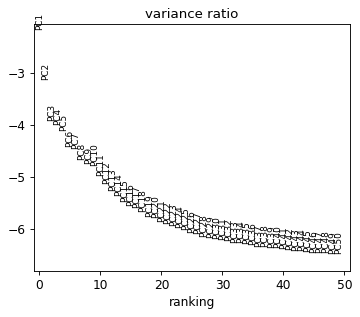

In [29]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [31]:
sorted_categories=[ 'Adult','Fetal',
    'NEr-fAOs','iPNECs','BTOs', 'dAOs/ALI']
adata.obs['Tissue'] = pd.Categorical(adata.obs['Tissue'], categories=sorted_categories)

In [32]:
adata.uns['Tissue_colors']=['#6A0572','#2EC4B6','#555555','#FFC300', '#FF5733', '#90EE90']
adata.uns['Tissue_colors']

['#6A0572', '#2EC4B6', '#555555', '#FFC300', '#FF5733', '#90EE90']

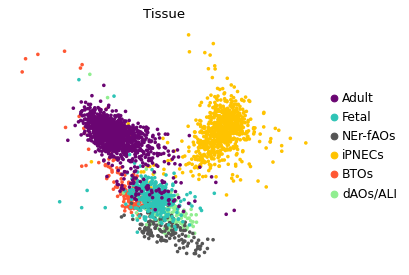

In [33]:
sc.pl.pca_scatter(adata, color=['Tissue'])

In [34]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=25)

2026-01-08 10:30:36.865524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-08 10:30:36.865628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-08 10:30:36.867696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-08 10:30:38.595587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [35]:
sc.tl.draw_graph(adata)

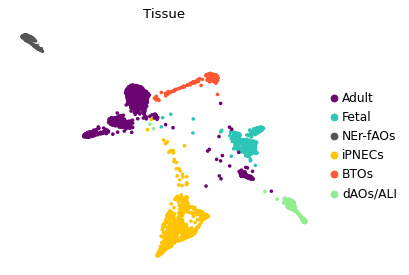

In [36]:
sc.pl.draw_graph(adata, color=['Tissue'], save='_Alignment_Neuroendocrine_day10_NOT_harmonized_Tissue.png')

# HARMONY INTEGRATION

In [37]:
sc.external.pp.harmony_integrate(adata, ['Technique','Sample ID'], basis='X_pca', adjusted_basis='X_pca_harmony')

2026-01-08 10:31:17,917 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2026-01-08 10:31:41,324 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2026-01-08 10:31:41,614 - harmonypy - INFO - Iteration 1 of 50
INFO:harmonypy:Iteration 1 of 50
2026-01-08 10:32:10,814 - harmonypy - INFO - Iteration 2 of 50
INFO:harmonypy:Iteration 2 of 50
2026-01-08 10:32:38,217 - harmonypy - INFO - Iteration 3 of 50
INFO:harmonypy:Iteration 3 of 50
2026-01-08 10:33:09,912 - harmonypy - INFO - Iteration 4 of 50
INFO:harmonypy:Iteration 4 of 50
2026-01-08 10:33:38,718 - harmonypy - INFO - Iteration 5 of 50
INFO:harmonypy:Iteration 5 of 50
2026-01-08 10:33:58,020 - harmonypy - INFO - Iteration 6 of 50
INFO:harmonypy:Iteration 6 of 50
2026-01-08 10:34:16,020 - harmonypy - INFO - Iteration 7 of 50
INFO:harmonypy:Iteration 7 of 50
2026-01-08 10:34:37,811 - 

INFO:harmonypy:Iteration 2 of 50


2024-11-04 17:16:59,513 - harmonypy - INFO - Iteration 3 of 50


INFO:harmonypy:Iteration 3 of 50


2024-11-04 17:16:59,844 - harmonypy - INFO - Iteration 4 of 50


INFO:harmonypy:Iteration 4 of 50


2024-11-04 17:17:00,174 - harmonypy - INFO - Iteration 5 of 50


INFO:harmonypy:Iteration 5 of 50


2024-11-04 17:17:00,505 - harmonypy - INFO - Iteration 6 of 50


INFO:harmonypy:Iteration 6 of 50


2024-11-04 17:17:00,836 - harmonypy - INFO - Iteration 7 of 50


INFO:harmonypy:Iteration 7 of 50


2024-11-04 17:17:01,095 - harmonypy - INFO - Iteration 8 of 50


INFO:harmonypy:Iteration 8 of 50


2024-11-04 17:17:01,427 - harmonypy - INFO - Iteration 9 of 50


INFO:harmonypy:Iteration 9 of 50


2024-11-04 17:17:01,723 - harmonypy - INFO - Iteration 10 of 50


INFO:harmonypy:Iteration 10 of 50


2024-11-04 17:17:02,053 - harmonypy - INFO - Iteration 11 of 50


INFO:harmonypy:Iteration 11 of 50


2024-11-04 17:17:02,372 - harmonypy - INFO - Iteration 12 of 50


INFO:harmonypy:Iteration 12 of 50


2024-11-04 17:17:02,702 - harmonypy - INFO - Iteration 13 of 50


INFO:harmonypy:Iteration 13 of 50


2024-11-04 17:17:02,997 - harmonypy - INFO - Iteration 14 of 50


INFO:harmonypy:Iteration 14 of 50


2024-11-04 17:17:03,328 - harmonypy - INFO - Iteration 15 of 50


INFO:harmonypy:Iteration 15 of 50


2024-11-04 17:17:03,623 - harmonypy - INFO - Iteration 16 of 50


INFO:harmonypy:Iteration 16 of 50


2024-11-04 17:17:03,918 - harmonypy - INFO - Converged after 16 iterations


INFO:harmonypy:Converged after 16 iterations


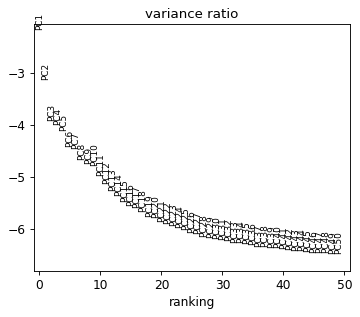

In [38]:
adata.obsm['prev_X_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [39]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=25)

In [40]:
sc.tl.draw_graph(adata)

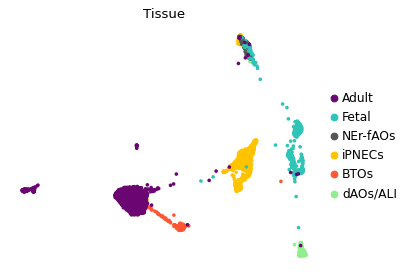

In [43]:
sc.pl.draw_graph(adata, color=['Tissue'], save='_Alignment_Neuroendocrine_day10_harmonized_tissue.png')

In [42]:
adata.write_h5ad('./data/Merged_Neuroendocrine_annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

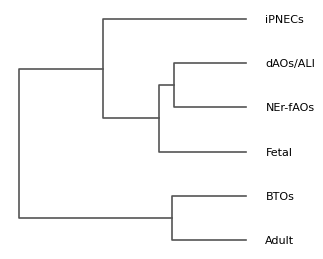

In [6]:
sc.tl.dendrogram(adata,groupby='Tissue',n_pcs=25,cor_method='pearson',optimal_ordering=True)
plt.figure(figsize=(4, 4))
ax = plt.gca()
sc.pl.dendrogram(adata, groupby='Tissue', ax=ax,orientation='left',save='_Alignment_Neuroendocrine_tissue')
plt.show()

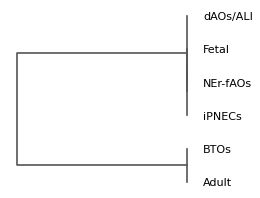

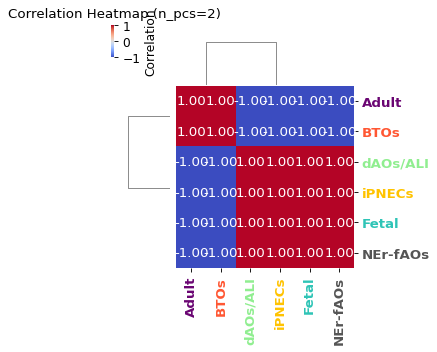

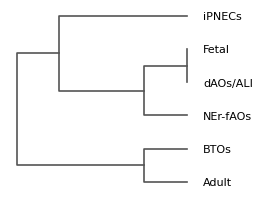

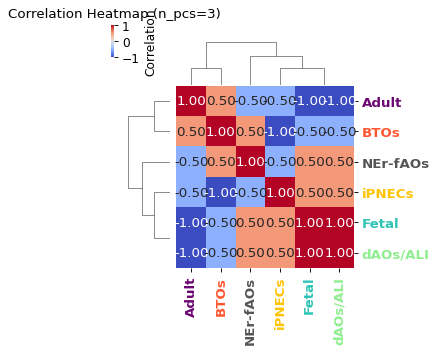

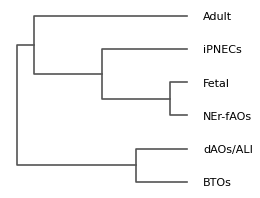

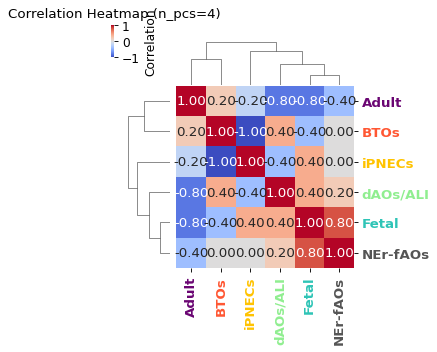

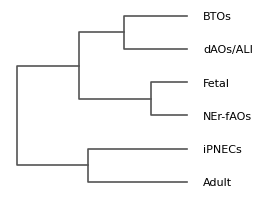

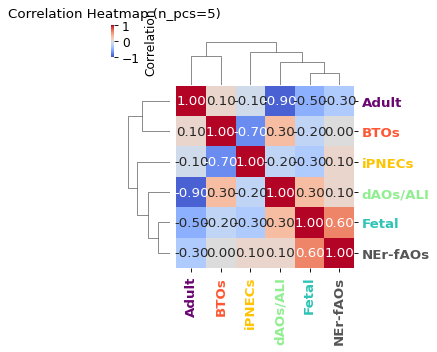

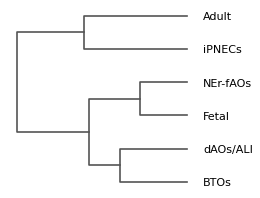

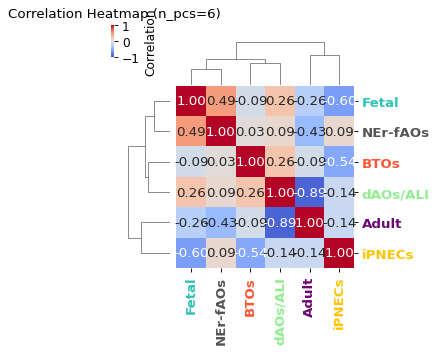

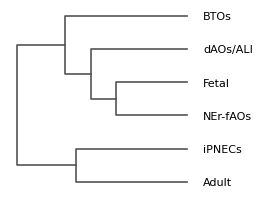

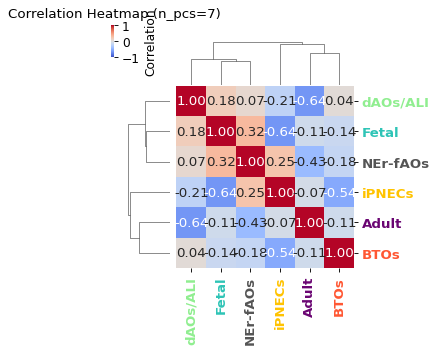

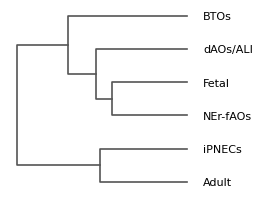

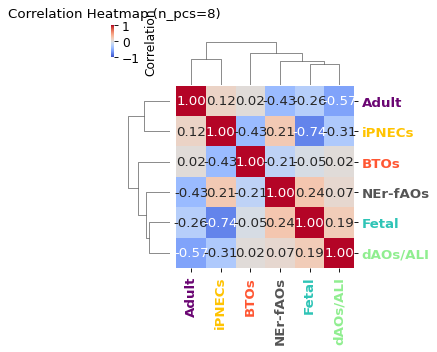

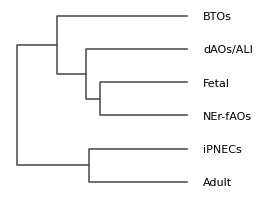

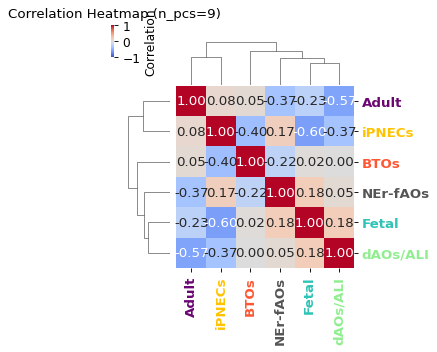

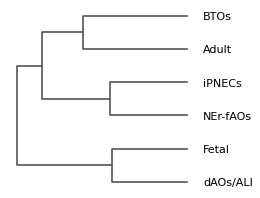

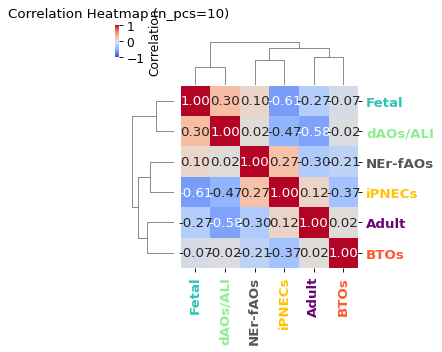

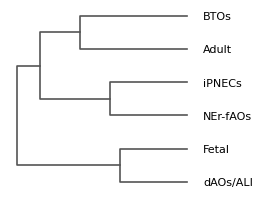

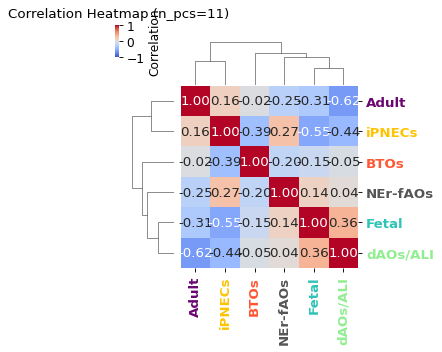

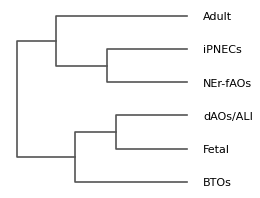

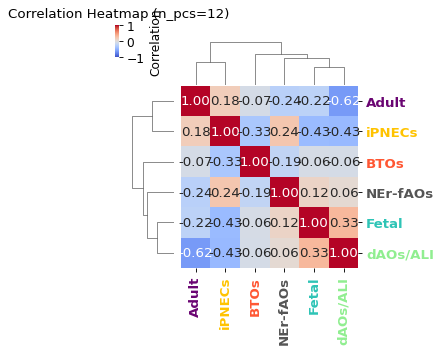

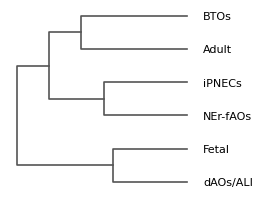

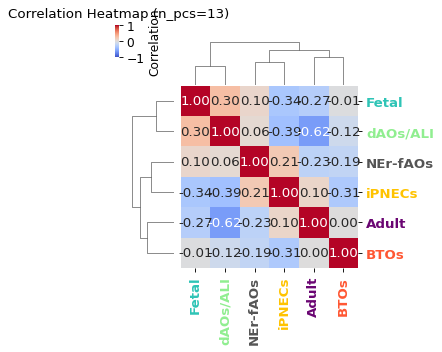

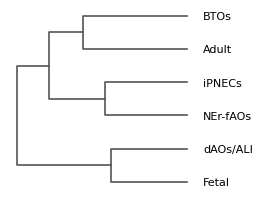

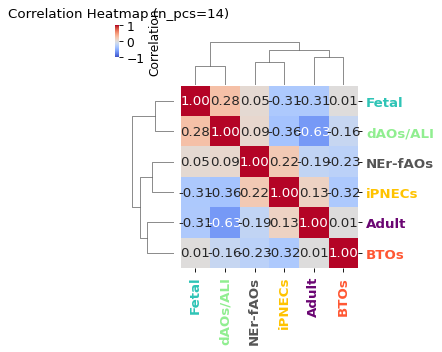

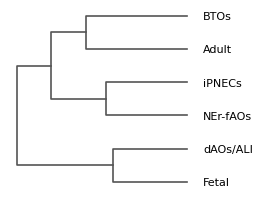

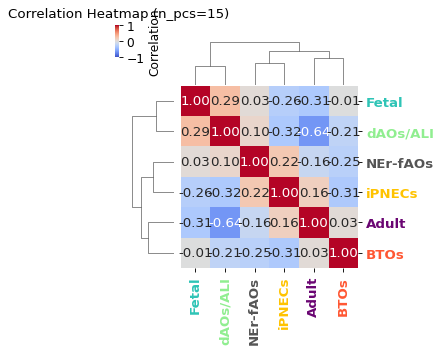

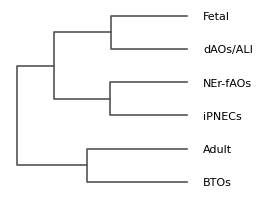

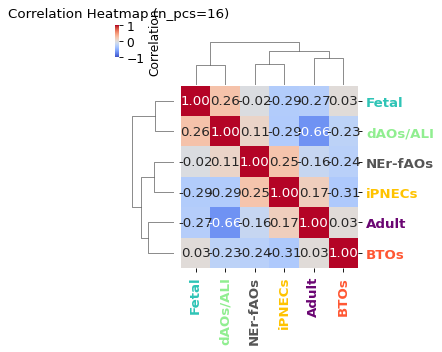

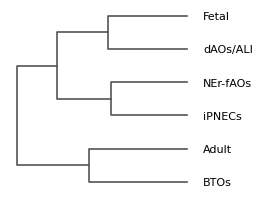

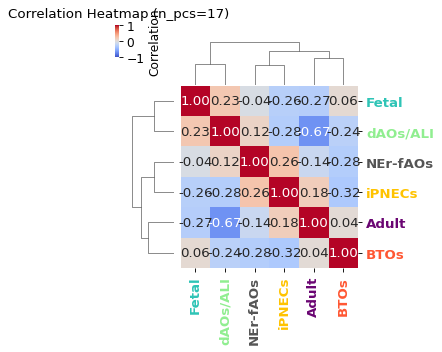

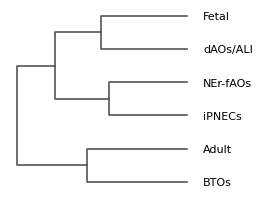

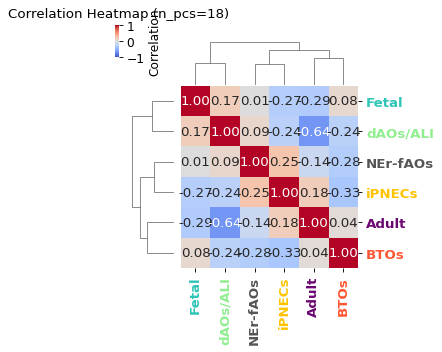

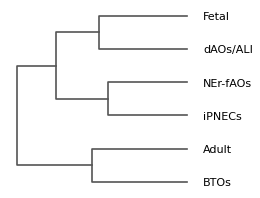

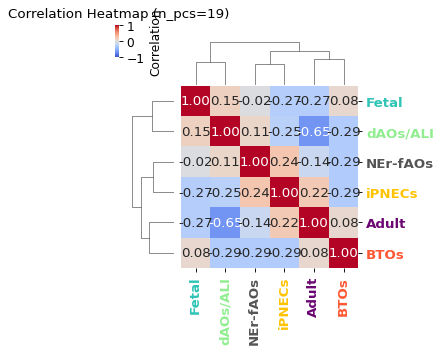

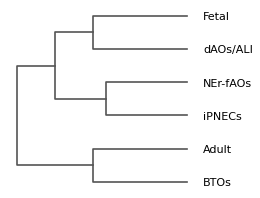

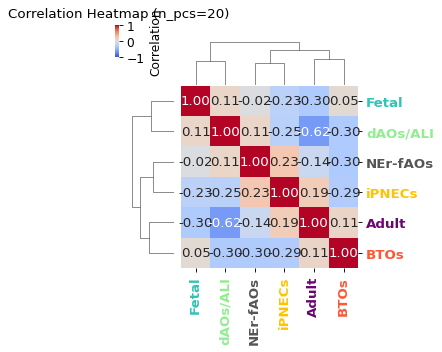

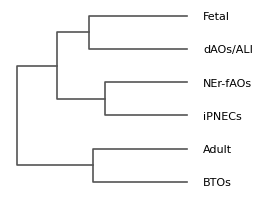

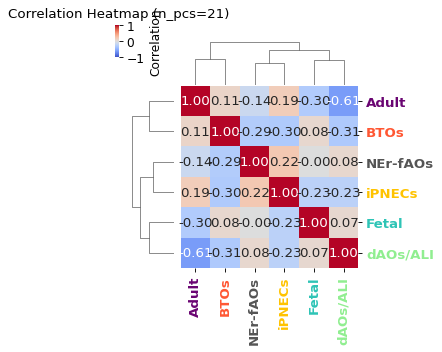

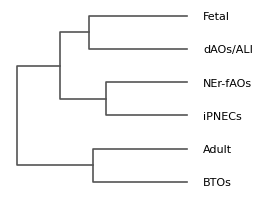

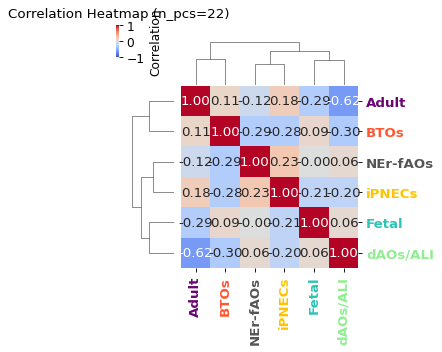

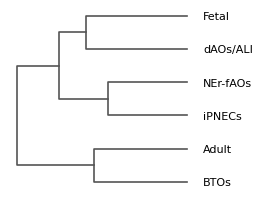

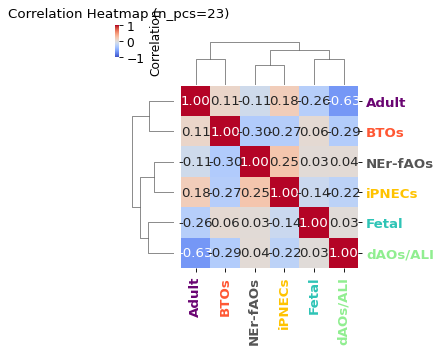

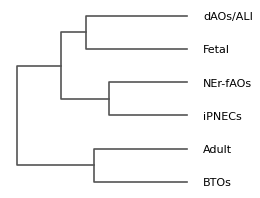

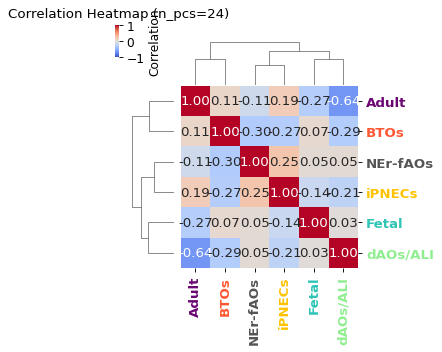

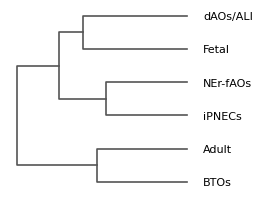

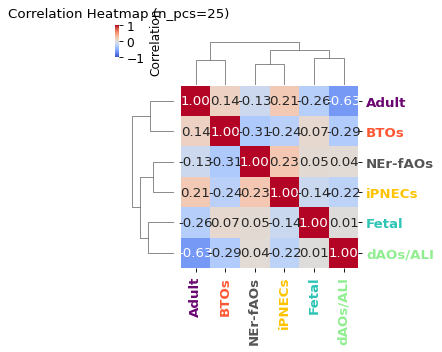

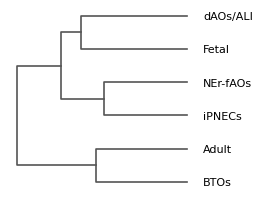

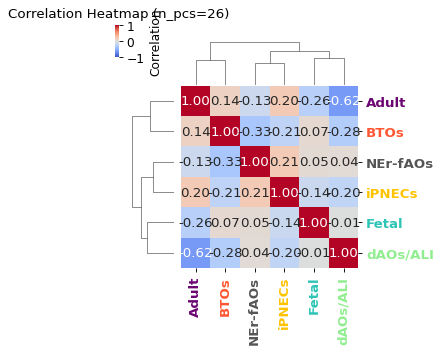

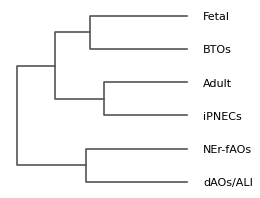

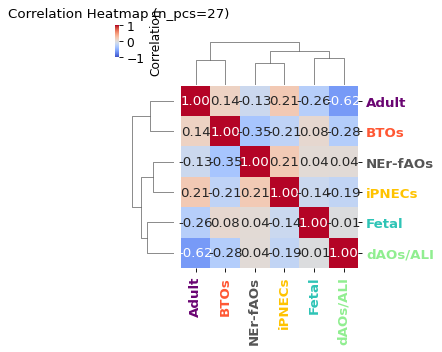

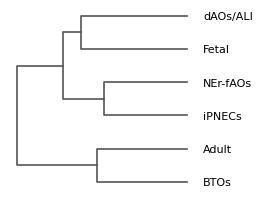

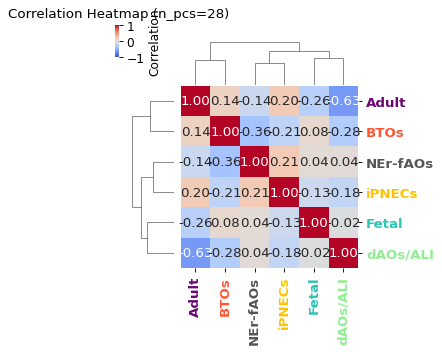

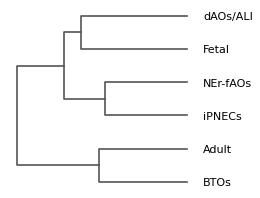

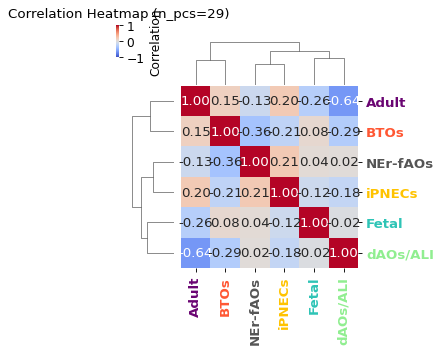

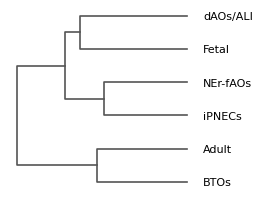

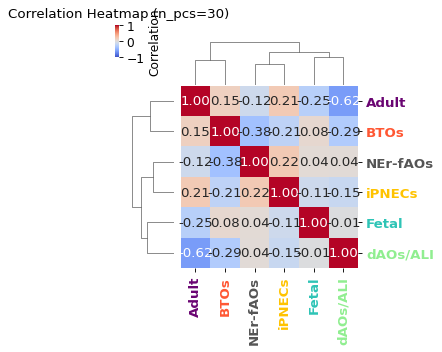

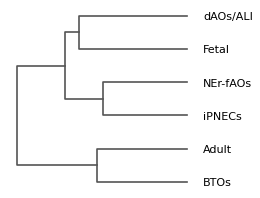

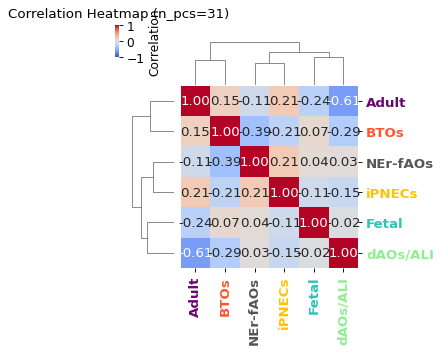

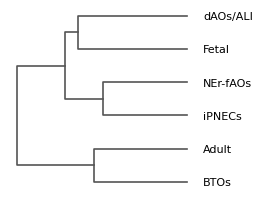

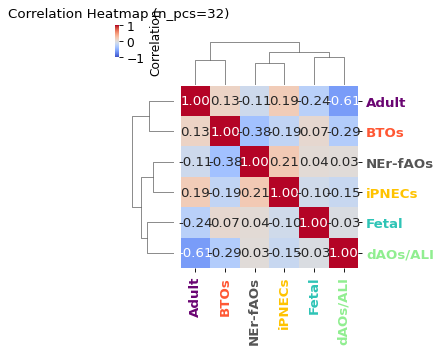

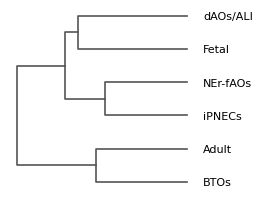

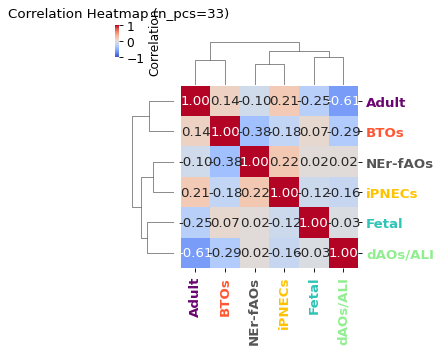

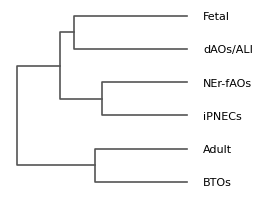

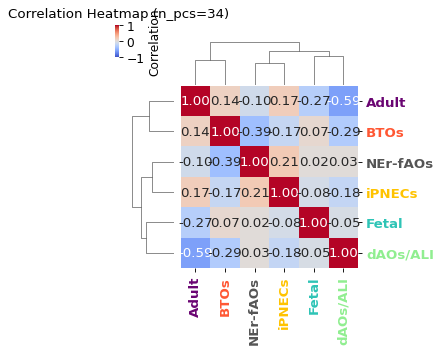

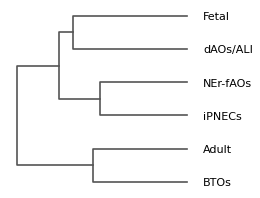

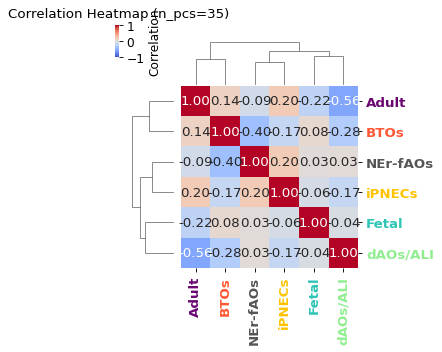

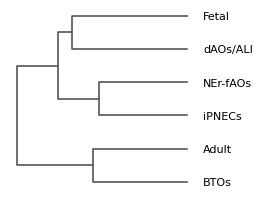

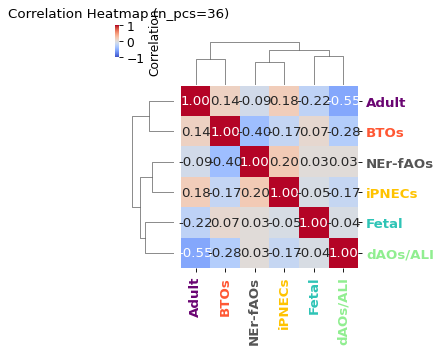

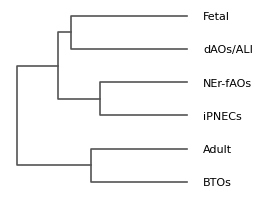

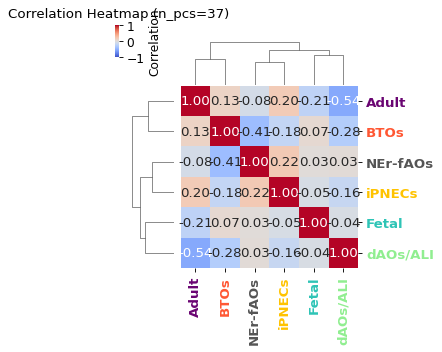

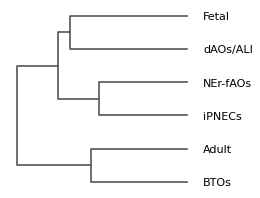

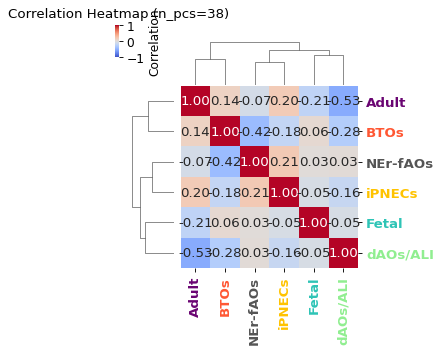

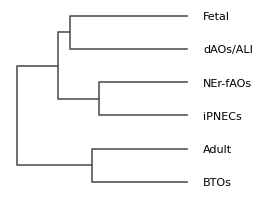

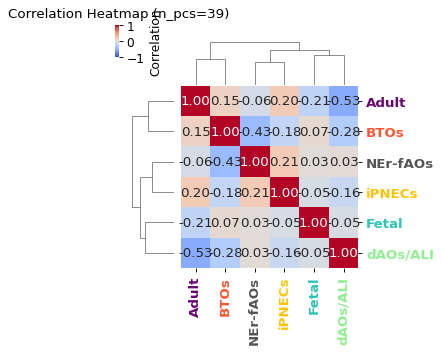

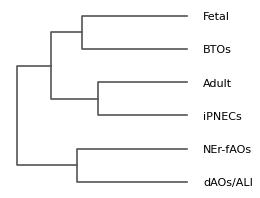

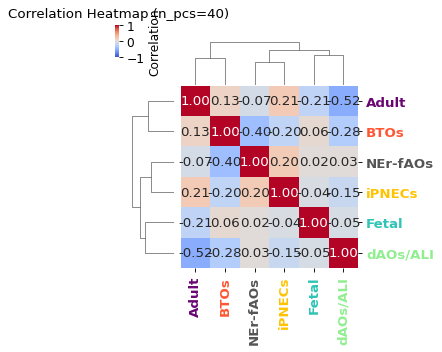

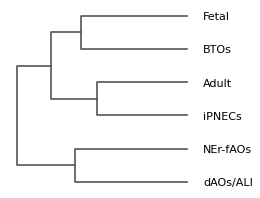

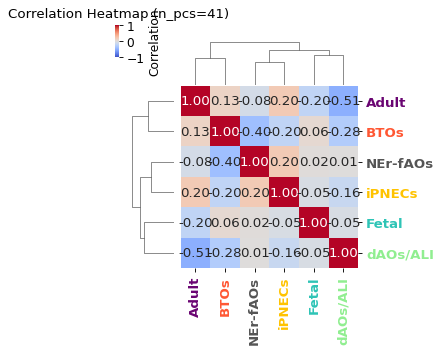

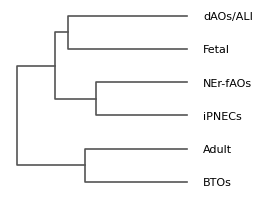

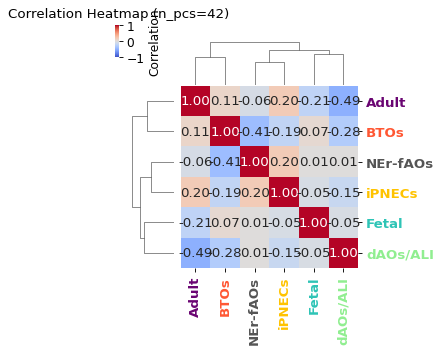

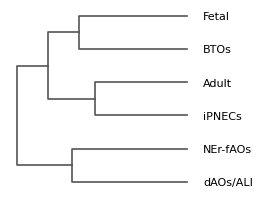

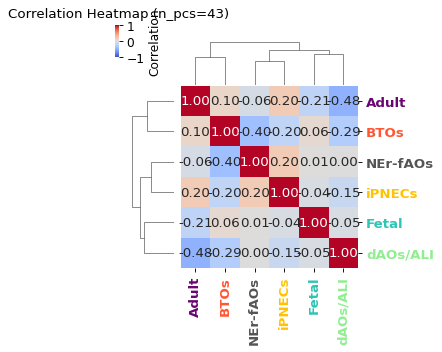

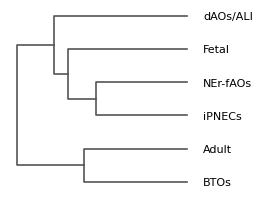

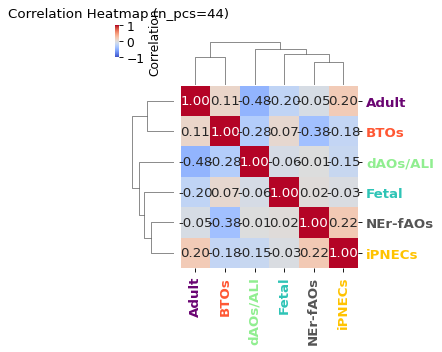

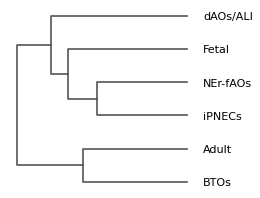

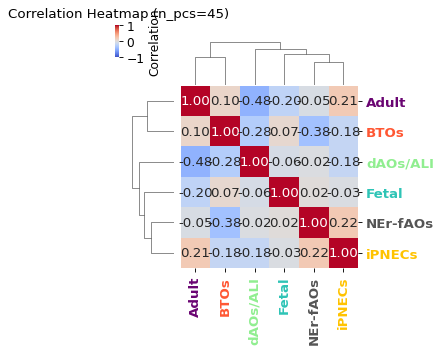

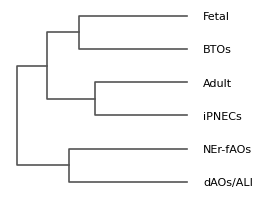

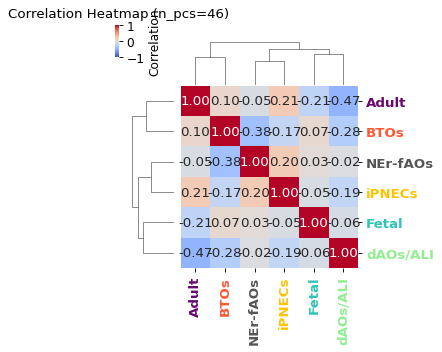

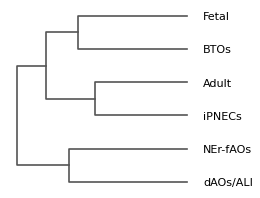

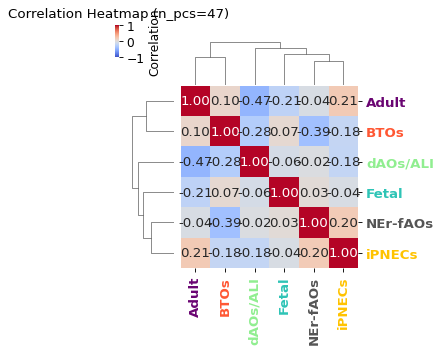

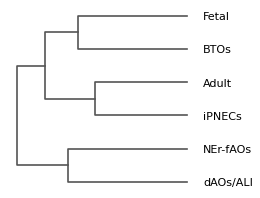

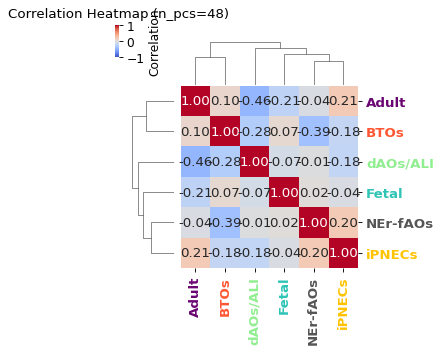

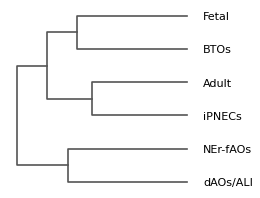

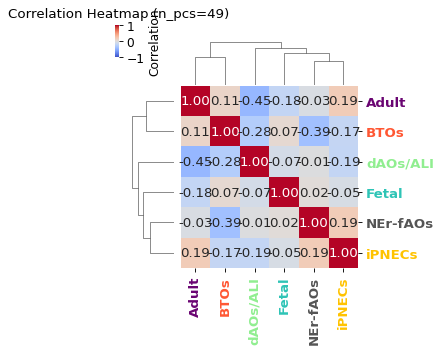

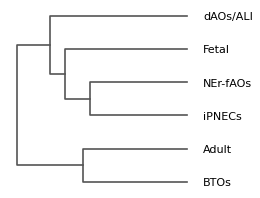

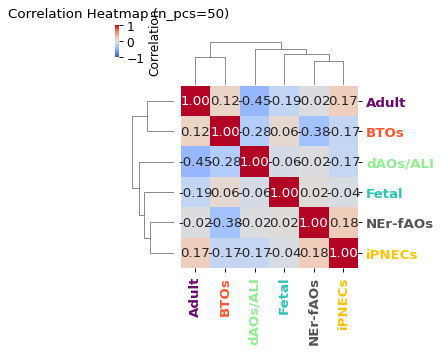

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy.cluster import hierarchy

figfolder = "./data/figures/"  # Set your figure output directory
os.makedirs(figfolder, exist_ok=True)  # Create the folder if it doesn't exist

for n in range(2, 51):  # Looping over n_pcs from 2 to 50
    key_name = f'Tissue_{n}PCAs'  # Unique key for each dendrogram
    
    # Compute dendrogram
    sc.tl.dendrogram(adata, groupby='Tissue', n_pcs=n, cor_method='spearman', optimal_ordering=True, key_added=key_name)
    
    # Plot dendrogram
    plt.figure(figsize=(3, 3))
    ax = plt.gca()
    sc.pl.dendrogram(adata, groupby='Tissue', dendrogram_key=key_name, ax=ax, orientation='left', save=f'_Alignment_Neuroendocrine_Tissue_{n}PCs')
    plt.show()
    
    # Extract ordered categories for proper correlation matrix indexing
    categories_ordered = adata.uns[key_name]['categories_ordered']
    categories_idx_ordered = adata.uns[key_name]['categories_idx_ordered']
    categories_dict = dict(zip(categories_idx_ordered, categories_ordered))
    categories_dict = dict(sorted(categories_dict.items(), key=lambda item: item[0]))

    # Extract correlation matrix
    correlation_matrix_array = adata.uns[key_name]['correlation_matrix']
    correlation_matrix_df = pd.DataFrame(
        correlation_matrix_array,
        index=list(categories_dict.values()),
        columns=list(categories_dict.values())
    )

    # Compute linkage for clustering
    linkage = hierarchy.linkage(correlation_matrix_df, method='complete')

    # Define a function to customize label colors
    def label_formatter(label):
        color_map = {
            'Adult': '#6A0572',
            'dAOs/ALI': '#90EE90',
            'NEr-fAOs': '#555555',
            'BTOs': '#FF5733',
            'Fetal': '#2EC4B6',
            'iPNECs': '#FFC300',
        }
        for key in color_map:
            if key in label:
                return color_map[key]
        return 'black'  # Default color if no match is found

    # Generate clustermap
    cluster = sns.clustermap(
        correlation_matrix_df,
        row_linkage=linkage,
        col_linkage=linkage,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        cbar_kws={'label': 'Correlation'},
        cbar_pos=(0, 0.9, 0.01, 0.1),  # Adjust colorbar position
        figsize=(4, 4),
        vmax=1,
        vmin=-1,
        xticklabels=True,
        yticklabels=True
    )

    # Customize x-axis labels
    for tick_label in cluster.ax_heatmap.get_xticklabels():
        label_text = tick_label.get_text()
        tick_label.set_color(label_formatter(label_text))
        tick_label.set_fontweight('bold')
        tick_label.set_fontsize(12)

    # Customize y-axis labels
    for tick_label in cluster.ax_heatmap.get_yticklabels():
        label_text = tick_label.get_text()
        tick_label.set_color(label_formatter(label_text))
        tick_label.set_fontweight('bold')
        tick_label.set_fontsize(12)

    # Add title
    plt.title(f'Correlation Heatmap (n_pcs={n})', x=1, y=1.05)

    # Save the plot
    save_path = os.path.join(figfolder, f'CorrelationHeatMap_Alignment_Neuroendocrine_Tissue_{n}PCs')
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# DEG Tissue (Neuroendocrine Genes)

In [5]:
adata=sc.read_h5ad('./data/Merged_Neuroendocrine_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 2838 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

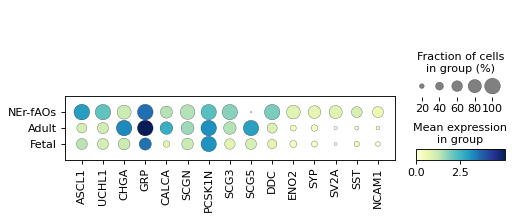

In [17]:
markers=['ASCL1','UCHL1','CHGA','GRP','CALCA','SCGN', 'PCSK1N', 'SCG3', 'SCG5','DDC','ENO2','SYP','SV2A','SST','NCAM1']

adata_filtered = adata[adata.obs["Tissue"].isin(['NEr-fAOs', 'Adult', 'Fetal'])]
sc.pl.dotplot(adata_filtered, var_names=markers, groupby="Tissue", 
              categories_order=['NEr-fAOs', 'Adult', 'Fetal'],
              cmap=cmap, vmin=0,
             save='_Neuroendocrine_PNEC_markers_tissue')

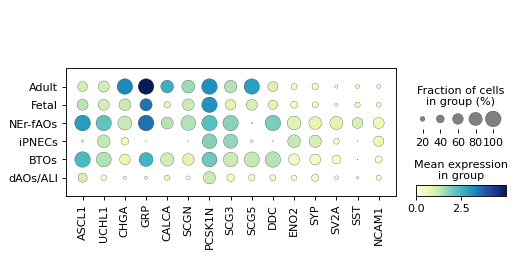

In [18]:
markers=['ASCL1','UCHL1','CHGA','GRP','CALCA','SCGN', 'PCSK1N', 'SCG3', 'SCG5','DDC','ENO2','SYP','SV2A','SST','NCAM1']

sc.pl.dotplot(adata, var_names=markers, groupby='Tissue',cmap=cmap,vmin=0,save='_Neuroendocrine_PNEC_markers_models')

# Barplot - Neuroendocrine Genes 

In [3]:
adata=sc.read_h5ad('./data/Merged_Neuroendocrine_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 2838 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [4]:
adata.layers['counts'] = adata.layers['counts']
adata.layers['CPM'] = adata.layers['counts']/adata.layers['counts'].sum()*1000000

In [5]:
neuroendocrinology_genes=[
    #Peptidergic
       'PCSK1N', 'GRP', 'CHGA', 'DBI', 'SCG3', 'SCG2',  'CHGB', 'SCG5',
       'CALCA', 'INHBA',  'INHBB', 'SST', 'NPW', 'GHRL', 'POMC',
       'VGF', 'NPPA', 'OTP',  'NMB', 'ADM',  'TRH', 'IGF1',
       'IGF2', 'CALCB', 'AGRP', 'TAC1', 'ADCYAP1', 'EDN1', 'PNOC', 'HCRT',
       'AGT', 'CRH', 'INHA',  'GAL',  'NPFF', 'GNRH1', 'CARTPT',
       'NPB', 'PENK', 'EDN3', 'NPPC', 'GNRH2', 'NPY',  'UCN', 'THPO',
        'NPPB', 'IAPP', 'OXT', 'CCK',  'GHRH',
    #Neuroetransmitters
    'DDC','TPH1', 'GLS','GAD1','GLS2','DBH','PNMT','HDC','GAD2','TPH2', 'TH']

In [6]:
mask = adata.obs['Tissue'].isin(['Fetal'])
adata_fetal = adata[mask]
adata_fetal

View of AnnData object with n_obs × n_vars = 422 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'int

In [7]:
mask = adata.obs['Tissue'].isin(['Adult'])
adata_adult = adata[mask]
adata_adult

View of AnnData object with n_obs × n_vars = 1155 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'in

In [8]:
mask = adata.obs['Tissue'].isin(['NEr-fAOs'])
adata_dayton = adata[mask]
adata_dayton

View of AnnData object with n_obs × n_vars = 140 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'int

In [9]:
mask = adata.obs['Tissue'].isin(['dAOs/ALI'])
adata_lee = adata[mask]
adata_lee

View of AnnData object with n_obs × n_vars = 171 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'int

In [10]:
mask = adata.obs['Tissue'].isin(['BTOs'])
adata_conchola_organoid = adata[mask]
adata_conchola_organoid

View of AnnData object with n_obs × n_vars = 164 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'int

In [11]:
mask = adata.obs['Tissue'].isin(['iPNECs'])
adata_iPNECs = adata[mask]
adata_iPNECs

View of AnnData object with n_obs × n_vars = 786 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'int

In [12]:
dfs_NE = {}

for gene in neuroendocrinology_genes:

    if gene not in adata.var_names:
        continue

    adult_mask = adata_adult[:, adata_adult.var_names == gene].layers['CPM'] > 0
    adult_pos = adata_adult[adult_mask]
    gene_index_adult = adult_pos.var_names.get_loc(gene)
    mean_expression_adult = adult_pos.layers['CPM'][:, gene_index_adult].mean()+1

    fetal_mask = adata_fetal[:, adata_fetal.var_names == gene].layers['CPM'] > 0
    fetal_pos = adata_fetal[fetal_mask]
    gene_index_fetal = fetal_pos.var_names.get_loc(gene)
    mean_expression_fetal = fetal_pos.layers['CPM'][:, gene_index_fetal].mean()+1
    
    dayton_mask = adata_dayton[:, adata_dayton.var_names == gene].layers['CPM'] > 0
    dayton_pos = adata_dayton[dayton_mask]
    gene_index_dayton = dayton_pos.var_names.get_loc(gene)
    mean_expression_dayton = dayton_pos.layers['CPM'][:, gene_index_dayton].mean()+1

    iPNECs_mask = adata_iPNECs[:, adata_iPNECs.var_names == gene].layers['CPM'] > 0
    iPNECs_pos = adata_iPNECs[iPNECs_mask]
    gene_index_iPNECs = iPNECs_pos.var_names.get_loc(gene)
    mean_expression_iPNECs = iPNECs_pos.layers['CPM'][:, gene_index_iPNECs].mean()+1

    conchola_organoid_mask = adata_conchola_organoid[:, adata_conchola_organoid.var_names == gene].layers['CPM'] > 0
    conchola_organoid_pos = adata_conchola_organoid[conchola_organoid_mask]
    gene_index_conchola_organoid = conchola_organoid_pos.var_names.get_loc(gene)
    mean_expression_conchola_organoid = conchola_organoid_pos.layers['CPM'][:, gene_index_conchola_organoid].mean()+1
    
    lee_mask = adata_lee[:, adata_lee.var_names == gene].layers['CPM'] > 0
    lee_pos = adata_lee[lee_mask]
    gene_index_lee = lee_pos.var_names.get_loc(gene)
    mean_expression_lee = lee_pos.layers['CPM'][:, gene_index_lee].mean()+1

    
    neg_mask = adata[:, adata.var_names == gene].layers['CPM'] == 0
    neg = adata[neg_mask]
    
    df_gene = {
        'Adult': len(adult_pos.obs_names),
        'Fetal': len(fetal_pos.obs_names),
        'NEr-fAOs': len(dayton_pos.obs_names),
        'iPNECs': len(iPNECs_pos.obs_names),
        'BTOs': len(conchola_organoid_pos.obs_names),
        'dAOs/ALI': len(lee_pos.obs_names),

        'Total NE cell (Adult)': len(adata_adult.obs_names),
        'Total NE cell (Fetal)': len(adata_fetal.obs_names),
        'Total NE cell (NEr-fAOs)': len(adata_dayton.obs_names),
        'Total NE cell (iPNECs)': len(adata_iPNECs.obs_names),
        'Total NE cell (BTOs)': len(adata_conchola_organoid.obs_names),
        'Total NE cell (dAOs/ALI)': len(adata_lee.obs_names),

        'Counts Adult': mean_expression_adult,       
        'Counts Fetal': mean_expression_fetal,
        'Counts NEr-fAOs': mean_expression_dayton,
        'Counts iPNECs': mean_expression_iPNECs,       
        'Counts BTOs': mean_expression_conchola_organoid,
        'Counts dAOs/ALI': mean_expression_lee,

    }
    
    dfs_NE[gene] = df_gene


In [13]:
dfs_NE

{'PCSK1N': {'Adult': 1138,
  'Fetal': 411,
  'NEr-fAOs': 136,
  'iPNECs': 716,
  'BTOs': 152,
  'dAOs/ALI': 123,
  'Total NE cell (Adult)': 1155,
  'Total NE cell (Fetal)': 422,
  'Total NE cell (NEr-fAOs)': 140,
  'Total NE cell (iPNECs)': 786,
  'Total NE cell (BTOs)': 164,
  'Total NE cell (dAOs/ALI)': 171,
  'Counts Adult': 1.6027922726710662,
  'Counts Fetal': 1.71012080906741,
  'Counts NEr-fAOs': 1.589671309325594,
  'Counts iPNECs': 1.2913504672379537,
  'Counts BTOs': 1.950007344113999,
  'Counts dAOs/ALI': 1.2976130570885713},
 'GRP': {'Adult': 1149,
  'Fetal': 301,
  'NEr-fAOs': 139,
  'iPNECs': 16,
  'BTOs': 140,
  'dAOs/ALI': 18,
  'Total NE cell (Adult)': 1155,
  'Total NE cell (Fetal)': 422,
  'Total NE cell (NEr-fAOs)': 140,
  'Total NE cell (iPNECs)': 786,
  'Total NE cell (BTOs)': 164,
  'Total NE cell (dAOs/ALI)': 171,
  'Counts Adult': 4.538942157432774,
  'Counts Fetal': 6.255429483963409,
  'Counts NEr-fAOs': 3.1359731204291554,
  'Counts iPNECs': 1.06455700836253

In [14]:
df_NE=pd.DataFrame.from_dict(dfs_NE, orient='index')
df_NE

Adult  Fetal  NEr-fAOs  iPNECs  BTOs  dAOs/ALI  Total NE cell (Adult)  \
PCSK1N   1138    411       136     716   152       123                   1155   
GRP      1149    301       139      16   140        18                   1155   
CHGA     1136    287       120     297    97        21                   1155   
DBI       706    253       119     502   161       166                   1155   
SCG3      853    247       136     686   149        64                   1155   
...       ...    ...       ...     ...   ...       ...                    ...   
PNMT        8     12         2      82     9         2                   1155   
HDC         0      5         0       1     0         0                   1155   
GAD2        4      4         0      26     2         0                   1155   
TPH2        0      0         0       5     2         0                   1155   
TH          0      1         0     101     0         0                   1155   

        Total NE cell (Fetal)  Total NE cell (NEr-fAOs)  \
PCSK1N                    422                       140   
GRP                       422                       140   
CHGA                      422                       140   
DBI                       422                       140   
SCG3                      422                       140   
...                       ...                       ...   
PNMT                      422                       140   
HDC                       422                       140   
GAD2                      422                       140   
TPH2                      422                       140   
TH                        422                       140   

        Total NE cell (iPNECs)  Total NE cell (BTOs)  \
PCSK1N                     786                   164   
GRP                        786                   164   
CHGA                       786                   164   
DBI                        786                   164   
SCG3                       786                   164   
...                        ...                   ...   
PNMT                       786                   164   
HDC                        786                   164   
GAD2                       786                   164   
TPH2                       786                   164   
TH                         786                   164   

        Total NE cell (dAOs/ALI)  Counts Adult  Counts Fetal  Counts NEr-fAOs  \
PCSK1N                       171      1.602792      1.710121         1.589671   
GRP                          171      4.538942      6.255429         3.135973   
CHGA                         171      1.540279      1.228896         1.198663   
DBI                          171      1.090768      1.102230         1.132629   
SCG3                         171      1.172870      1.082968         1.348760   
...                          ...           ...           ...              ...   
PNMT                         171      1.041316      1.044760         1.041316   
HDC                          171      1.000000      1.049580         1.000000   
GAD2                         171      1.061975      1.041316         1.000000   
TPH2                         171      1.000000      1.000000         1.000000   
TH                           171      1.000000      1.041316         1.000000   

        Counts iPNECs  Counts BTOs  Counts dAOs/ALI  
PCSK1N       1.291350     1.950007         1.297613  
GRP          1.064557     4.046796         1.504979  
CHGA         1.079572     1.284104         1.072796  
DBI          1.091522     1.578174         1.256610  
SCG3         1.299876     1.300030         1.146544  
...               ...          ...              ...  
PNMT         1.056936     1.041316         1.041316  
HDC          1.041316     1.000000         1.000000  
GAD2         1.069920     1.144608         1.000000  
TPH2         1.041316     1.041316         1.000000  
TH           1.097769     1.000000         1.000000  

[61 rows x 18 columns]

In [15]:
df_NE_perc_sorted=df_NE.copy()

df_NE_perc_sorted['Adult']=df_NE['Adult']/df_NE['Total NE cell (Adult)']*100
df_NE_perc_sorted['Fetal']=df_NE['Fetal']/df_NE['Total NE cell (Fetal)']*100
df_NE_perc_sorted['NEr-fAOs']=df_NE['NEr-fAOs']/df_NE['Total NE cell (NEr-fAOs)']*100
df_NE_perc_sorted['iPNECs']=df_NE['iPNECs']/df_NE['Total NE cell (iPNECs)']*100
df_NE_perc_sorted['BTOs']=df_NE['BTOs']/df_NE['Total NE cell (BTOs)']*100
df_NE_perc_sorted['dAOs/ALI']=df_NE['dAOs/ALI']/df_NE['Total NE cell (dAOs/ALI)']*100

df_NE_perc_sorted['Counts Adult'] = df_NE_perc_sorted['Counts Adult'].round(1)
df_NE_perc_sorted['Counts Fetal'] = df_NE_perc_sorted['Counts Fetal'].round(1)
df_NE_perc_sorted['Counts NEr-fAOs'] = df_NE_perc_sorted['Counts NEr-fAOs'].round(1)
df_NE_perc_sorted['Counts iPNECs'] = df_NE_perc_sorted['Counts iPNECs'].round(1)
df_NE_perc_sorted['Counts BTOs'] = df_NE_perc_sorted['Counts BTOs'].round(1)
df_NE_perc_sorted['Counts dAOs/ALI'] = df_NE_perc_sorted['Counts dAOs/ALI'].round(1)

df_NE_perc_sorted['Sorting']=df_NE['Adult']+df_NE['Fetal']+df_NE['NEr-fAOs']
df_NE_perc_sorted = df_NE_perc_sorted.sort_values(by='Sorting', ascending=False)
df_NE_perc_sorted

Adult      Fetal   NEr-fAOs     iPNECs       BTOs   dAOs/ALI  \
PCSK1N  98.528139  97.393365  97.142857  91.094148  92.682927  71.929825   
GRP     99.480519  71.327014  99.285714   2.035623  85.365854  10.526316   
CHGA    98.354978  68.009479  85.714286  37.786260  59.146341  12.280702   
SCG5    97.575758  62.322275   4.285714   9.923664  95.121951  30.994152   
SCG3    73.852814  58.530806  97.142857  87.277354  90.853659  37.426901   
...           ...        ...        ...        ...        ...        ...   
PNOC     0.000000   0.710900   0.000000   0.000000   0.609756   0.000000   
OXT      0.173160   0.236967   0.000000   0.127226   0.609756   0.000000   
IAPP     0.086580   0.000000   0.000000   0.890585   0.000000   0.000000   
TH       0.000000   0.236967   0.000000  12.849873   0.000000   0.000000   
TPH2     0.000000   0.000000   0.000000   0.636132   1.219512   0.000000   

        Total NE cell (Adult)  Total NE cell (Fetal)  \
PCSK1N                   1155                    422   
GRP                      1155                    422   
CHGA                     1155                    422   
SCG5                     1155                    422   
SCG3                     1155                    422   
...                       ...                    ...   
PNOC                     1155                    422   
OXT                      1155                    422   
IAPP                     1155                    422   
TH                       1155                    422   
TPH2                     1155                    422   

        Total NE cell (NEr-fAOs)  Total NE cell (iPNECs)  \
PCSK1N                       140                     786   
GRP                          140                     786   
CHGA                         140                     786   
SCG5                         140                     786   
SCG3                         140                     786   
...                          ...                     ...   
PNOC                         140                     786   
OXT                          140                     786   
IAPP                         140                     786   
TH                           140                     786   
TPH2                         140                     786   

        Total NE cell (BTOs)  Total NE cell (dAOs/ALI)  Counts Adult  \
PCSK1N                   164                       171           1.6   
GRP                      164                       171           4.5   
CHGA                     164                       171           1.5   
SCG5                     164                       171           1.4   
SCG3                     164                       171           1.2   
...                      ...                       ...           ...   
PNOC                     164                       171           1.0   
OXT                      164                       171           1.0   
IAPP                     164                       171           1.0   
TH                       164                       171           1.0   
TPH2                     164                       171           1.0   

        Counts Fetal  Counts NEr-fAOs  Counts iPNECs  Counts BTOs  \
PCSK1N           1.7              1.6            1.3          2.0   
GRP              6.3              3.1            1.1          4.0   
CHGA             1.2              1.2            1.1          1.3   
SCG5             1.1              1.0            1.1          1.3   
SCG3             1.1              1.3            1.3          1.3   
...              ...              ...            ...          ...   
PNOC             1.1              1.0            1.0          1.0   
OXT              1.0              1.0            1.0          1.0   
IAPP             1.0              1.0            1.0          1.0   
TH               1.0              1.0            1.1          1.0   
TPH2             1.0              1.0            1.0          1.0   

        Cou

In [16]:
df_NE_perc=df_NE.copy()

df_NE_perc['Adult']=df_NE['Adult']/df_NE['Total NE cell (Adult)']*100
df_NE_perc['Fetal']=df_NE['Fetal']/df_NE['Total NE cell (Fetal)']*100
df_NE_perc['NEr-fAOs']=df_NE['NEr-fAOs']/df_NE['Total NE cell (NEr-fAOs)']*100
df_NE_perc['iPNECs']=df_NE['iPNECs']/df_NE['Total NE cell (iPNECs)']*100
df_NE_perc['BTOs']=df_NE['BTOs']/df_NE['Total NE cell (BTOs)']*100
df_NE_perc['dAOs/ALI']=df_NE['dAOs/ALI']/df_NE['Total NE cell (dAOs/ALI)']*100

df_NE_perc['Counts Adult'] = df_NE_perc['Counts Adult'].round(1)
df_NE_perc['Counts Fetal'] = df_NE_perc['Counts Fetal'].round(1)
df_NE_perc['Counts NEr-fAOs'] = df_NE_perc['Counts NEr-fAOs'].round(1)
df_NE_perc['Counts iPNECs'] = df_NE_perc['Counts iPNECs'].round(1)
df_NE_perc['Counts BTOs'] = df_NE_perc['Counts BTOs'].round(1)
df_NE_perc['Counts dAOs/ALI'] = df_NE_perc['Counts dAOs/ALI'].round(1)
df_NE_perc

Adult      Fetal   NEr-fAOs     iPNECs       BTOs   dAOs/ALI  \
PCSK1N  98.528139  97.393365  97.142857  91.094148  92.682927  71.929825   
GRP     99.480519  71.327014  99.285714   2.035623  85.365854  10.526316   
CHGA    98.354978  68.009479  85.714286  37.786260  59.146341  12.280702   
DBI     61.125541  59.952607  85.000000  63.867684  98.170732  97.076023   
SCG3    73.852814  58.530806  97.142857  87.277354  90.853659  37.426901   
...           ...        ...        ...        ...        ...        ...   
PNMT     0.692641   2.843602   1.428571  10.432570   5.487805   1.169591   
HDC      0.000000   1.184834   0.000000   0.127226   0.000000   0.000000   
GAD2     0.346320   0.947867   0.000000   3.307888   1.219512   0.000000   
TPH2     0.000000   0.000000   0.000000   0.636132   1.219512   0.000000   
TH       0.000000   0.236967   0.000000  12.849873   0.000000   0.000000   

        Total NE cell (Adult)  Total NE cell (Fetal)  \
PCSK1N                   1155                    422   
GRP                      1155                    422   
CHGA                     1155                    422   
DBI                      1155                    422   
SCG3                     1155                    422   
...                       ...                    ...   
PNMT                     1155                    422   
HDC                      1155                    422   
GAD2                     1155                    422   
TPH2                     1155                    422   
TH                       1155                    422   

        Total NE cell (NEr-fAOs)  Total NE cell (iPNECs)  \
PCSK1N                       140                     786   
GRP                          140                     786   
CHGA                         140                     786   
DBI                          140                     786   
SCG3                         140                     786   
...                          ...                     ...   
PNMT                         140                     786   
HDC                          140                     786   
GAD2                         140                     786   
TPH2                         140                     786   
TH                           140                     786   

        Total NE cell (BTOs)  Total NE cell (dAOs/ALI)  Counts Adult  \
PCSK1N                   164                       171           1.6   
GRP                      164                       171           4.5   
CHGA                     164                       171           1.5   
DBI                      164                       171           1.1   
SCG3                     164                       171           1.2   
...                      ...                       ...           ...   
PNMT                     164                       171           1.0   
HDC                      164                       171           1.0   
GAD2                     164                       171           1.1   
TPH2                     164                       171           1.0   
TH                       164                       171           1.0   

        Counts Fetal  Counts NEr-fAOs  Counts iPNECs  Counts BTOs  \
PCSK1N           1.7              1.6            1.3          2.0   
GRP              6.3              3.1            1.1          4.0   
CHGA             1.2              1.2            1.1          1.3   
DBI              1.1              1.1            1.1          1.6   
SCG3             1.1              1.3            1.3          1.3   
...              ...              ...            ...          ...   
PNMT             1.0              1.0            1.1          1.0   
HDC              1.0              1.0            1.0          1.0   
GAD2             1.0              1.0            1.1          1.1   
TPH2             1.0              1.0            1.0          1.0   
TH               1.0              1.0            1.1          1.0   

        Cou

In [17]:
df_NE_perc_filtered = df_NE_perc_sorted[
(df_NE_perc_sorted['Adult'] < 5) &
    (df_NE_perc_sorted['Fetal'] < 5) &
    (df_NE_perc_sorted['NEr-fAOs'] < 5)]

df_NE_perc_filtered
df_NE_perc_filtered.to_csv("./data/markers/df_NE_filtered.csv", index=True)
df_NE_perc_filtered

Adult     Fetal  NEr-fAOs     iPNECs       BTOs   dAOs/ALI  \
HCRT    2.510823  3.080569  1.428571   2.162850  12.804878   1.169591   
CARTPT  3.463203  0.000000  0.000000   0.127226   0.000000   0.000000   
DBH     2.251082  1.421801  1.428571   0.763359   1.219512   1.754386   
IGF1    1.038961  4.739336  0.714286   4.580153   0.000000  15.789474   
CRH     0.952381  4.265403  0.714286   0.000000   2.439024   0.584795   
EDN1    1.298701  1.895735  2.857143   3.562341   3.048780   1.754386   
PENK    1.298701  1.895735  1.428571   3.180662   0.609756   0.000000   
PNMT    0.692641  2.843602  1.428571  10.432570   5.487805   1.169591   
INHA    0.432900  1.658768  2.142857   1.399491   6.097561   0.000000   
GHRH    1.125541  0.473934  0.000000   1.781170   0.000000   0.000000   
NPPB    1.038961  0.000000  1.428571   0.636132   1.829268   0.584795   
NPY     0.952381  0.710900  0.000000   0.127226   0.609756   0.000000   
GNRH1   0.259740  1.421801  3.571429   1.017812   1.219512   1.754386   
NPPC    0.519481  1.421801  0.000000   9.414758  10.975610   2.923977   
GNRH2   0.952381  0.000000  0.000000   0.127226   0.000000   0.000000   
GAL     0.519481  1.184834  0.000000   8.524173   0.609756   0.584795   
UCN     0.606061  0.710900  0.000000   3.180662   0.609756   0.584795   
NPB     0.259740  1.421801  0.714286   2.417303   1.219512   0.584795   
GAD2    0.346320  0.947867  0.000000   3.307888   1.219512   0.000000   
CCK     0.519481  0.000000  0.000000   5.343511   0.000000   1.169591   
THPO    0.086580  1.184834  0.000000   0.000000   1.219512   0.000000   
HDC     0.000000  1.184834  0.000000   0.127226   0.000000   0.000000   
NPFF    0.000000  0.000000  2.857143   3.816794   4.268293   2.923977   
EDN3    0.000000  0.473934  0.714286   0.127226   3.048780   0.000000   
PNOC    0.000000  0.710900  0.000000   0.000000   0.609756   0.000000   
OXT     0.173160  0.236967  0.000000   0.127226   0.609756   0.000000   
IAPP    0.086580  0.000000  0.000000   0.890585   0.000000   0.000000   
TH      0.000000  0.236967  0.000000  12.849873   0.000000   0.000000   
TPH2    0.000000  0.000000  0.000000   0.636132   1.219512   0.000000   

        Total NE cell (Adult)  Total NE cell (Fetal)  \
HCRT                     1155                    422   
CARTPT                   1155                    422   
DBH                      1155                    422   
IGF1                     1155                    422   
CRH                      1155                    422   
EDN1                     1155                    422   
PENK                     1155                    422   
PNMT                     1155                    422   
INHA                     1155                    422   
GHRH                     1155                    422   
NPPB                     1155                    422   
NPY                      1155                    422   
GNRH1                    1155                    422   
NPPC                     1155                    422   
GNRH2                    1155                    422   
GAL                      1155                    422   
UCN                      1155                    422   
NPB                      1155                    422   
GAD2                     1155                    422   
CCK                      1155                    422   
THPO                     1155                    422   
HDC                      1155                    422   
NPFF                     1155                    422   
EDN3                     1155                    422   
PNOC                     1155                    422   
OXT                      1155                    422   
IAPP                     1155                    422   
TH                       1155                    422   
TPH2                     1155                    422   

        Total NE cell (NEr-fAOs)  Total NE cell (iPNECs)  \
HCRT                         140                     786   
CARTPT             

In [18]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

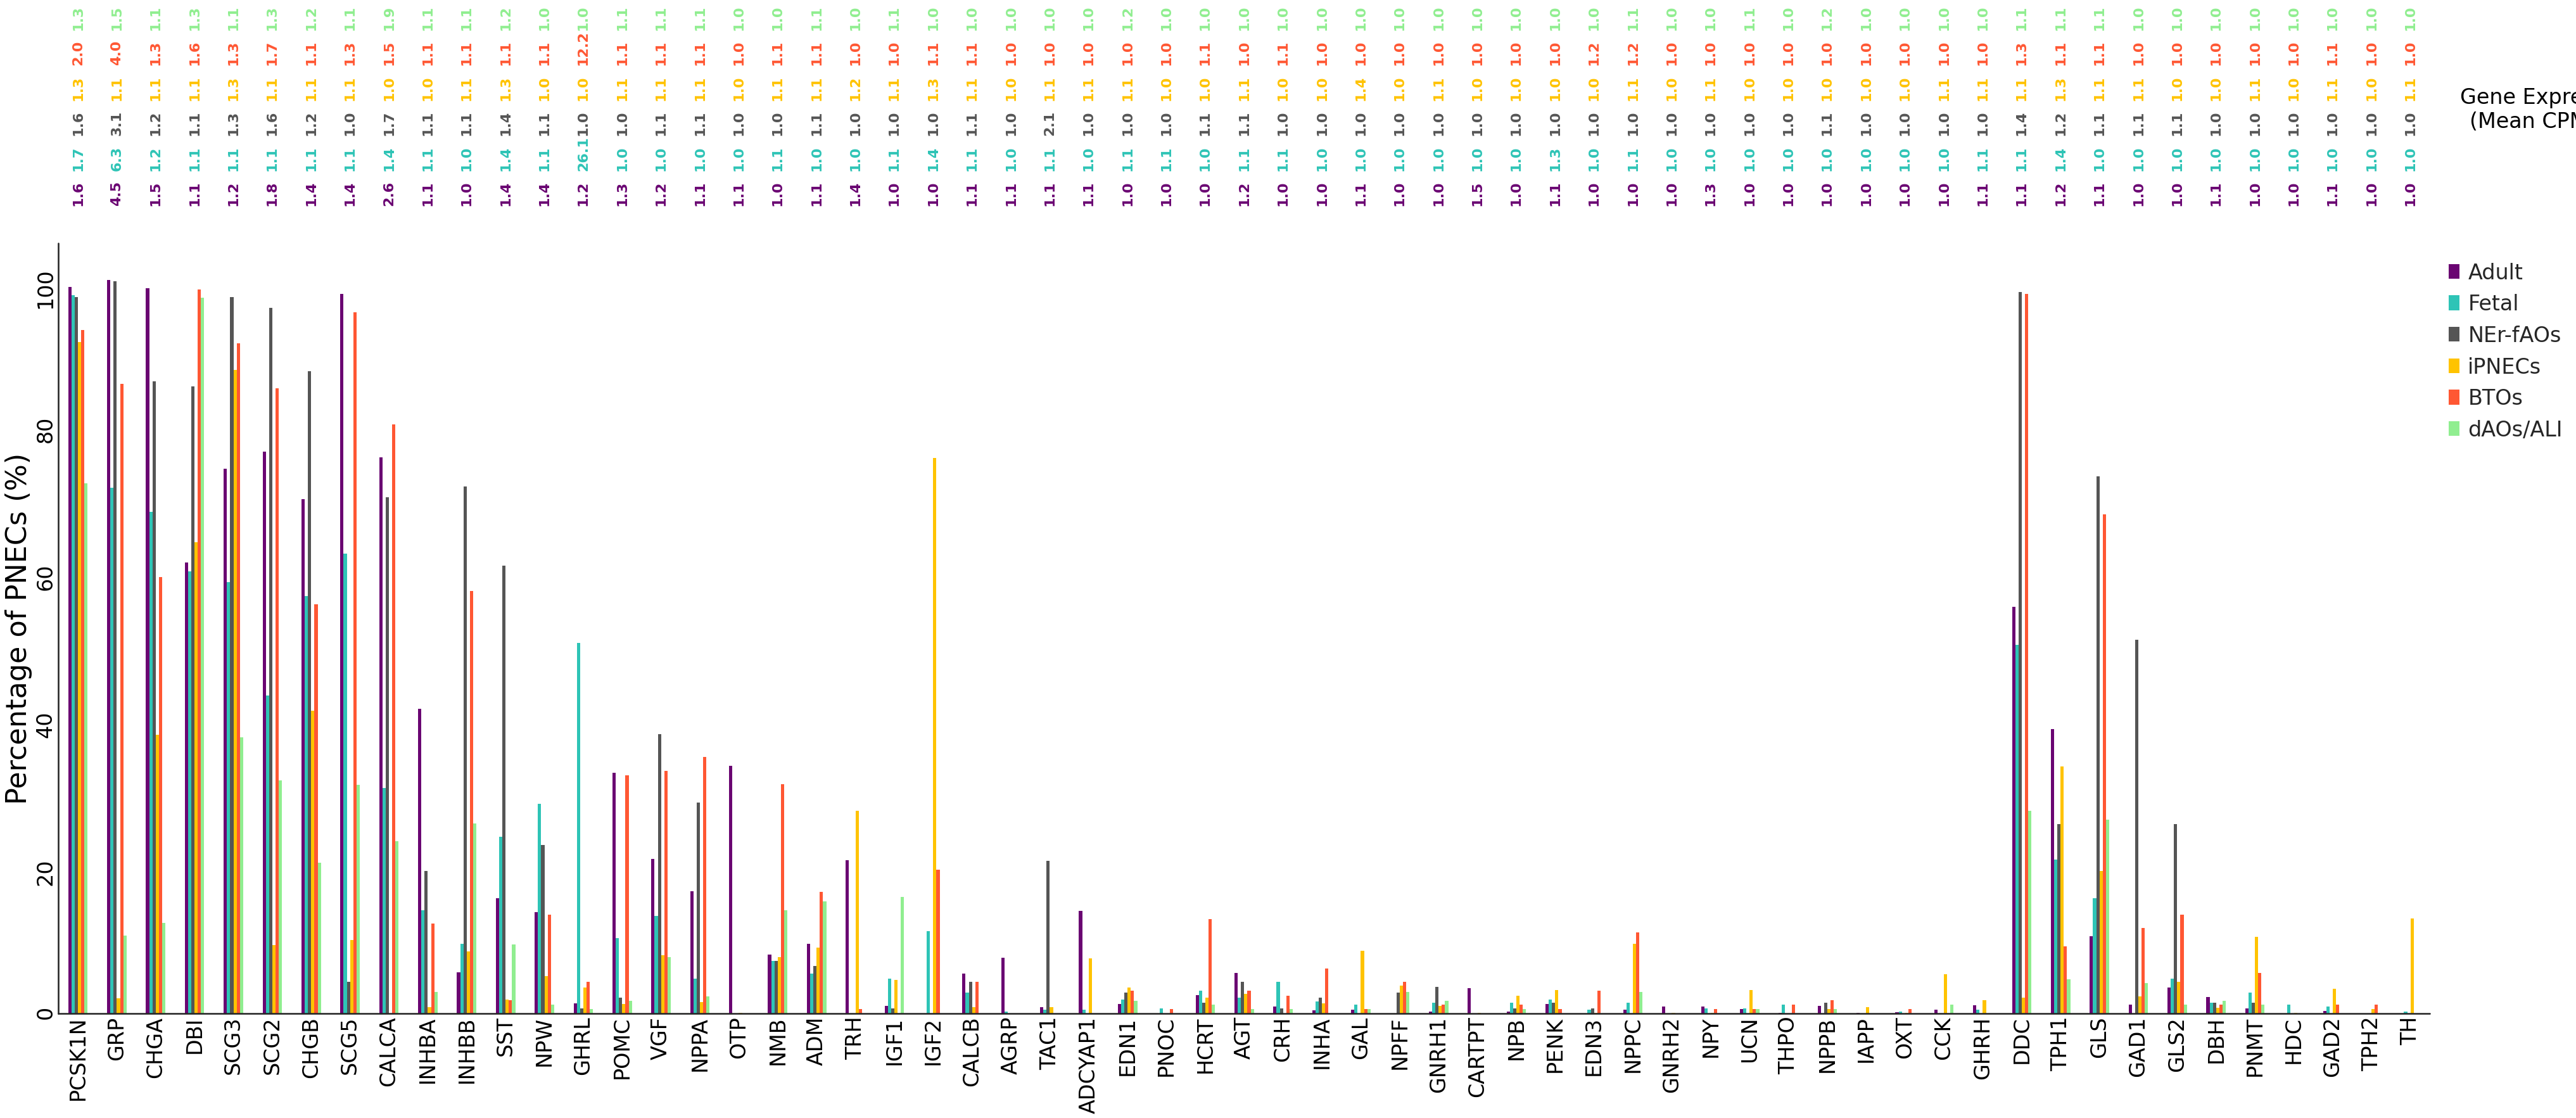

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
# Set the figure size and style based on your preference
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(60, 20))

# Use the bar function to create a stacked bar plot
df_plot = df_NE_perc[['Adult','Fetal','NEr-fAOs',
                     'iPNECs','BTOs','dAOs/ALI']]

df_plot.plot(kind='bar', stacked=False, color=['#6A0572','#2EC4B6','#555555','#FFC300', '#FF5733', '#90EE90'],
             edgecolor=None,width=0.5, ax=ax)

# Customize the plot
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=30)
plt.yticks(size=30,color='black',rotation=90)
plt.xticks(rotation=90, size=30, color='black')
plt.ylabel("Percentage of PNECs (%)", size = 40, color='black')

# Add another axis on top with corresponding ticks and values
ax_adult = ax.twiny()
ax_adult.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_adult.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_adult.spines['top'].set_position(('outward', 50))
ax_adult.set_xticklabels(df_NE_perc['Counts Adult'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#6A0572')

ax_fetal = ax.twiny()
ax_fetal.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_fetal.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_fetal.spines['top'].set_position(('outward', 100))
ax_fetal.set_xticklabels(df_NE_perc['Counts Fetal'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#2EC4B6')

ax_dayton = ax.twiny()
ax_dayton.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_dayton.set_xticks(ax.get_xticks()) # Set the positions of the ticks
ax_dayton.spines['top'].set_position(('outward', 150))
ax_dayton.set_xticklabels(df_NE_perc['Counts NEr-fAOs'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#555555')
ax_dayton.xaxis.set_label_coords(1.05, 1.05)  # Adjust the label position

ax_iPNECs = ax.twiny()
ax_iPNECs.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_iPNECs.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_iPNECs.spines['top'].set_position(('outward', 200))
ax_iPNECs.set_xticklabels(df_NE_perc['Counts iPNECs'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#FFC300')

ax_conchola_organoid = ax.twiny()
ax_conchola_organoid.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_conchola_organoid.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_conchola_organoid.spines['top'].set_position(('outward', 250))
ax_conchola_organoid.set_xticklabels(df_NE_perc['Counts BTOs'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#FF5733')

ax_lee = ax.twiny()
ax_lee.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_lee.set_xticks(ax.get_xticks()) # Set the positions of the ticks
ax_lee.spines['top'].set_position(('outward', 300))
ax_lee.set_xticklabels(df_NE_perc['Counts dAOs/ALI'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#90EE90')

ax_lee.set_xlabel("Gene Expression\n(Mean CPM+1)", size=30, color='black')
ax_lee.xaxis.set_label_coords(1.05, 1.15)  # Adjust the label position

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax_adult.spines['top'].set_visible(False)
ax_fetal.spines['top'].set_visible(False)
ax_dayton.spines['top'].set_visible(False)
ax_iPNECs.spines['top'].set_visible(False)
ax_conchola_organoid.spines['top'].set_visible(False)
ax_lee.spines['top'].set_visible(False)
ax_adult.spines['right'].set_visible(False)
ax_fetal.spines['right'].set_visible(False)
ax_dayton.spines['right'].set_visible(False)
ax_iPNECs.spines['right'].set_visible(False)
ax_conchola_organoid.spines['right'].set_visible(False)
ax_lee.spines['right'].set_visible(False)

plt.savefig(os.path.join(figfolder,'BarPlot_Alignment_Neuroendocrine_day10_all_NE_genes.pdf'),
            bbox_inches='tight', pad_inches=2)

# Show the plot
plt.show()

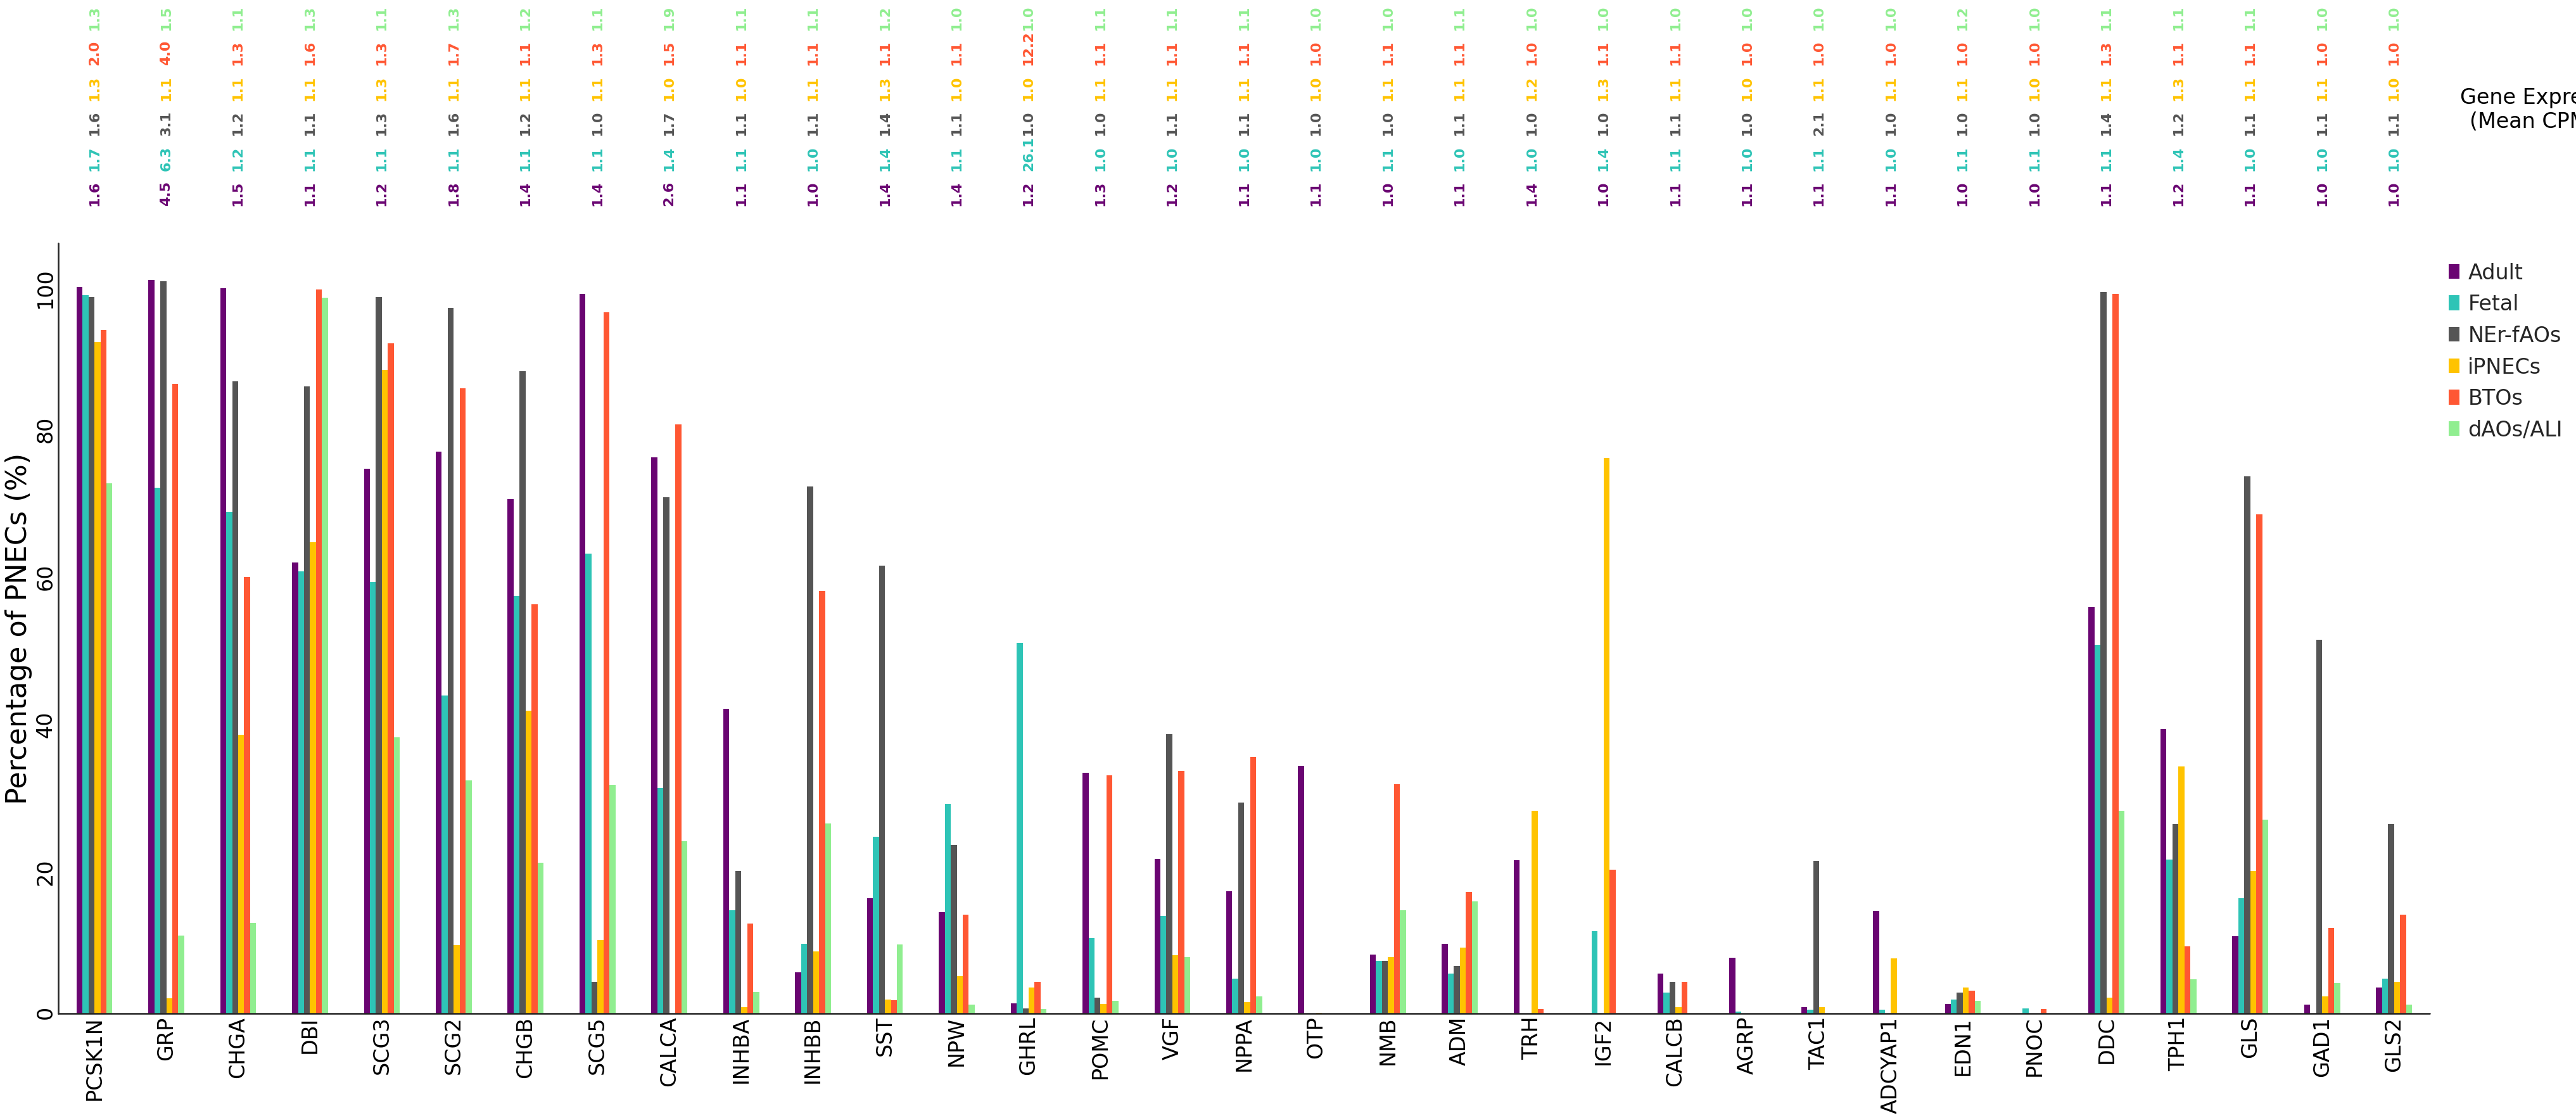

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
# Set the figure size and style based on your preference
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(60, 20))

# Use the bar function to create a stacked bar plot
genes=[
    #Peptidergic
       'PCSK1N', 'GRP', 'CHGA', 'DBI', 'SCG3', 'SCG2',  'CHGB', 'SCG5',
       'CALCA', 'INHBA',  'INHBB', 'SST', 'NPW', 'GHRL', 'POMC',
       'VGF', 'NPPA', 'OTP',  'NMB', 'ADM',  'TRH',
       'IGF2', 'CALCB', 'AGRP', 'TAC1', 'ADCYAP1', 'EDN1', 'PNOC',
    #Neuroetransmitters
    'DDC','TPH1', 'GLS','GAD1','GLS2']

df_NE_perc_NE = df_NE_perc[df_NE.index.isin(genes)]

df_plot = df_NE_perc_NE[['Adult','Fetal','NEr-fAOs',
                     'iPNECs','BTOs','dAOs/ALI']]

df_plot.plot(kind='bar', stacked=False, color=['#6A0572','#2EC4B6','#555555','#FFC300', '#FF5733', '#90EE90'],
             edgecolor=None,width=0.5, ax=ax)

# Customize the plot
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=30)
plt.yticks(size=30,color='black',rotation=90)
plt.xticks(rotation=90, size=30, color='black')
plt.ylabel("Percentage of PNECs (%)", size = 40, color='black')

# Add another axis on top with corresponding ticks and values
ax_adult = ax.twiny()
ax_adult.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_adult.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_adult.spines['top'].set_position(('outward', 50))
ax_adult.set_xticklabels(df_NE_perc_NE['Counts Adult'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#6A0572')

ax_fetal = ax.twiny()
ax_fetal.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_fetal.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_fetal.spines['top'].set_position(('outward', 100))
ax_fetal.set_xticklabels(df_NE_perc_NE['Counts Fetal'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#2EC4B6')

ax_dayton = ax.twiny()
ax_dayton.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_dayton.set_xticks(ax.get_xticks()) # Set the positions of the ticks
ax_dayton.spines['top'].set_position(('outward', 150))
ax_dayton.set_xticklabels(df_NE_perc_NE['Counts NEr-fAOs'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#555555')
ax_dayton.xaxis.set_label_coords(1.05, 1.05)  # Adjust the label position

ax_iPNECs = ax.twiny()
ax_iPNECs.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_iPNECs.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_iPNECs.spines['top'].set_position(('outward', 200))
ax_iPNECs.set_xticklabels(df_NE_perc_NE['Counts iPNECs'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#FFC300')

ax_conchola_organoid = ax.twiny()
ax_conchola_organoid.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_conchola_organoid.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_conchola_organoid.spines['top'].set_position(('outward', 250))
ax_conchola_organoid.set_xticklabels(df_NE_perc_NE['Counts BTOs'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#FF5733')

ax_lee = ax.twiny()
ax_lee.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_lee.set_xticks(ax.get_xticks()) # Set the positions of the ticks
ax_lee.spines['top'].set_position(('outward', 300))
ax_lee.set_xticklabels(df_NE_perc_NE['Counts dAOs/ALI'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#90EE90')

ax_lee.set_xlabel("Gene Expression\n(Mean CPM+1)", size=30, color='black')
ax_lee.xaxis.set_label_coords(1.05, 1.15)  # Adjust the label position

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax_adult.spines['top'].set_visible(False)
ax_fetal.spines['top'].set_visible(False)
ax_dayton.spines['top'].set_visible(False)
ax_iPNECs.spines['top'].set_visible(False)
ax_conchola_organoid.spines['top'].set_visible(False)
ax_lee.spines['top'].set_visible(False)
ax_adult.spines['right'].set_visible(False)
ax_fetal.spines['right'].set_visible(False)
ax_dayton.spines['right'].set_visible(False)
ax_iPNECs.spines['right'].set_visible(False)
ax_conchola_organoid.spines['right'].set_visible(False)
ax_lee.spines['right'].set_visible(False)

plt.savefig(os.path.join(figfolder,'BarPlot_Alignment_Neuroendocrine_day10_NE_genes.pdf'),
            bbox_inches='tight', pad_inches=2)

# Show the plot
plt.show()

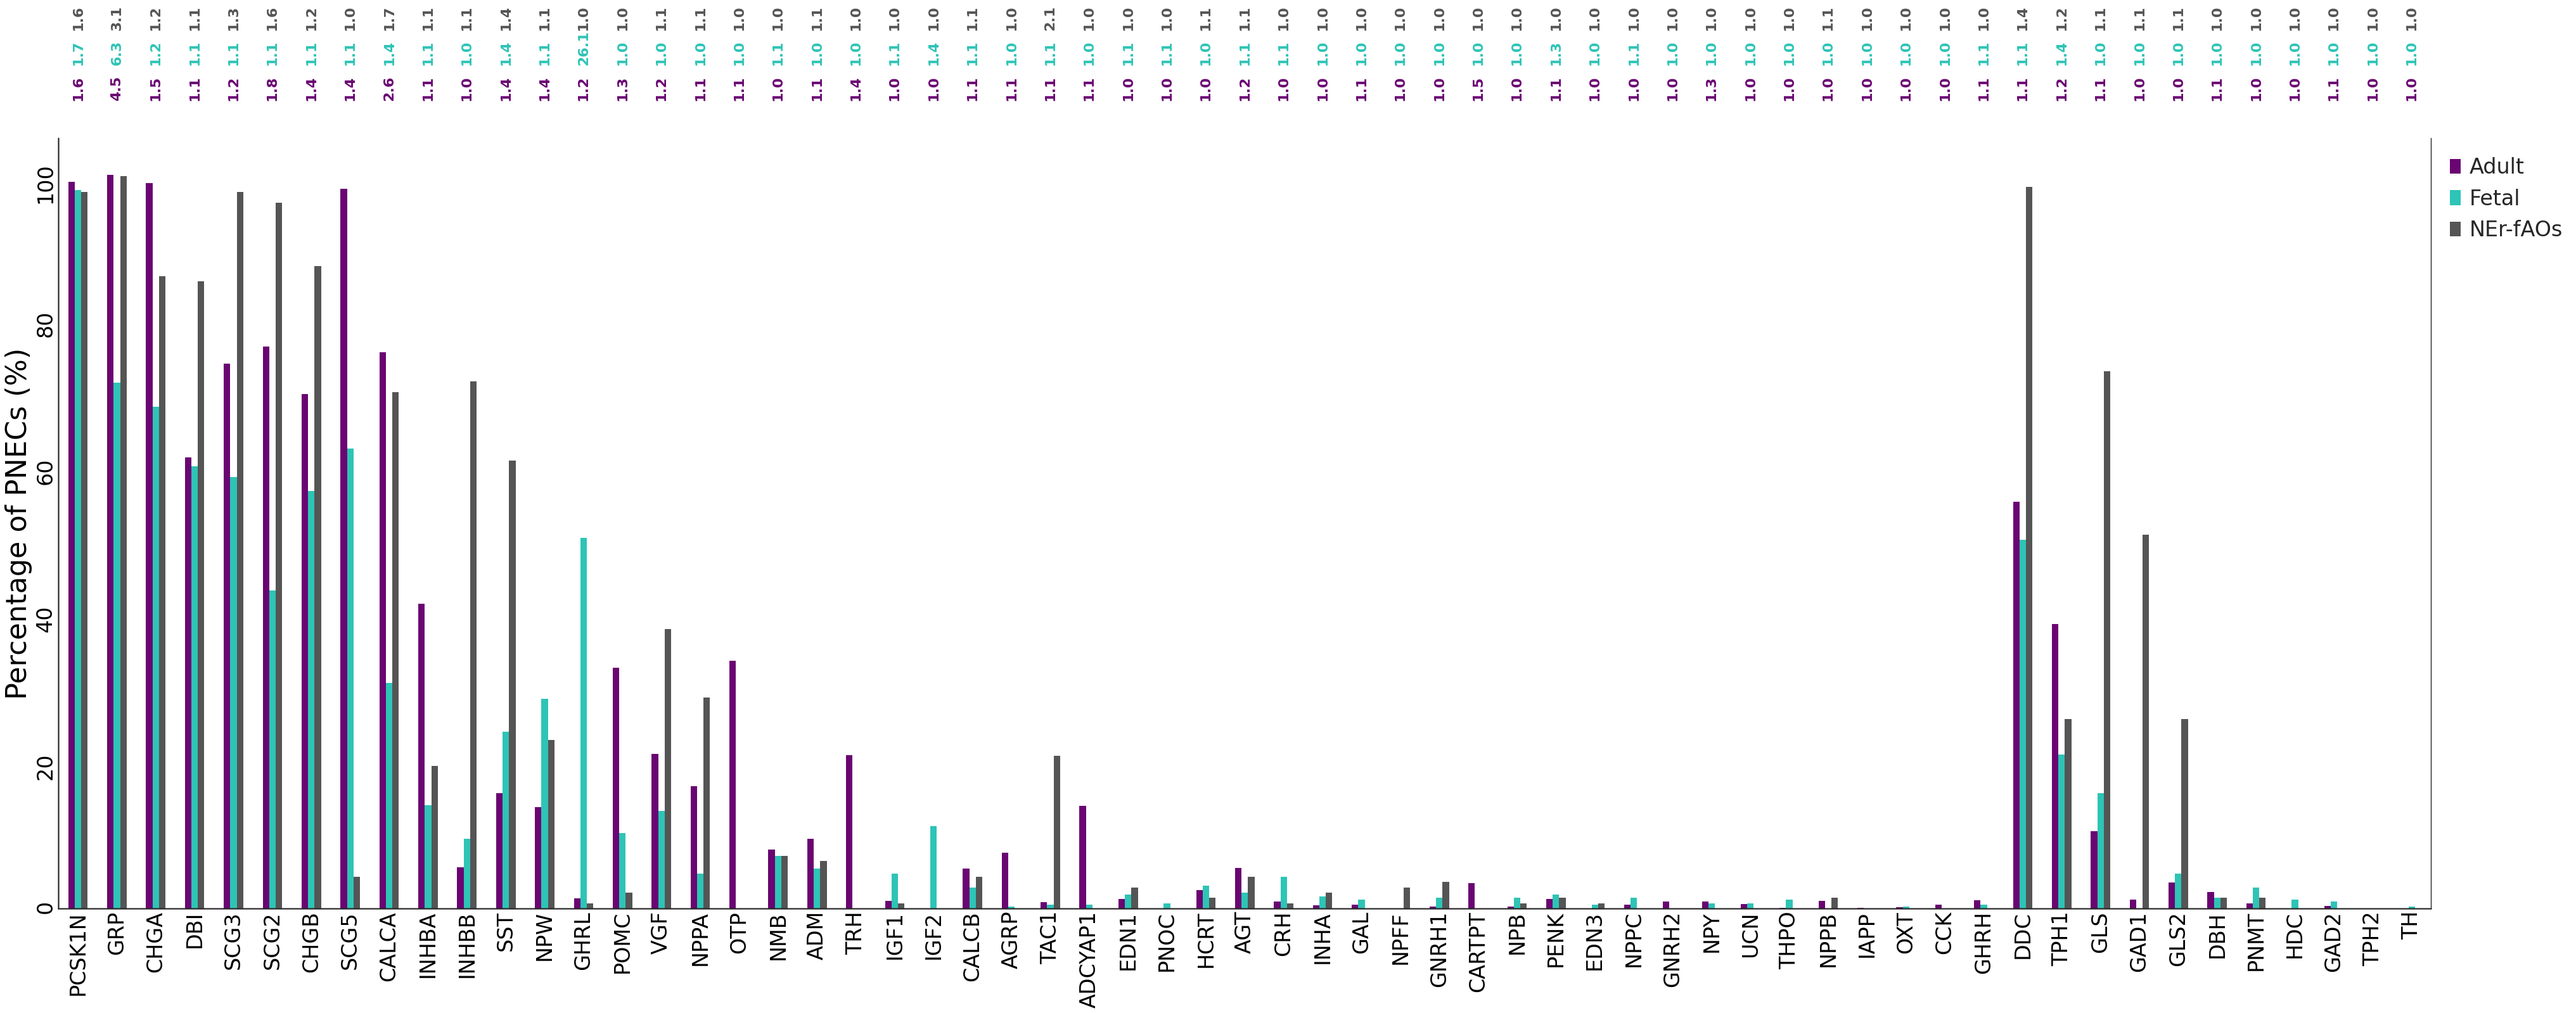

In [26]:
# Set the figure size and style based on your preference
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(60, 20))

# Use the bar function to create a stacked bar plot
df_plot = df_NE_perc[['Adult','Fetal','NEr-fAOs']]

df_plot.plot(kind='bar', stacked=False, color=['#6A0572','#2EC4B6','#555555'],
             edgecolor=None,width=0.5, ax=ax)

# Customize the plot
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=30)
plt.yticks(size=30,color='black',rotation=90)
plt.xticks(rotation=90, size=30, color='black')
plt.ylabel("Percentage of PNECs (%)", size = 40, color='black')

# Add another axis on top with corresponding ticks and values
ax_adult = ax.twiny()
ax_adult.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_adult.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_adult.spines['top'].set_position(('outward', 50))
ax_adult.set_xticklabels(df_NE_perc['Counts Adult'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#6A0572')

ax_fetal = ax.twiny()
ax_fetal.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_fetal.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_fetal.spines['top'].set_position(('outward', 100))
ax_fetal.set_xticklabels(df_NE_perc['Counts Fetal'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#2EC4B6')

ax_dayton = ax.twiny()
ax_dayton.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_dayton.set_xticks(ax.get_xticks()) # Set the positions of the ticks
ax_dayton.spines['top'].set_position(('outward', 150))
ax_dayton.set_xticklabels(df_NE_perc['Counts NEr-fAOs'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#555555')
ax_dayton.xaxis.set_label_coords(1.05, 1.05)  # Adjust the label position

ax_lee.set_xlabel("Gene Expression\n(Mean CPM+1)", size=30, color='black')
ax_lee.xaxis.set_label_coords(1.05, 1.15)  # Adjust the label position

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax_adult.spines['top'].set_visible(False)
ax_fetal.spines['top'].set_visible(False)
ax_dayton.spines['top'].set_visible(False)
ax_lee.spines['top'].set_visible(False)
ax_adult.spines['right'].set_visible(False)
ax_fetal.spines['right'].set_visible(False)
ax_conchola_organoid.spines['right'].set_visible(False)
ax_lee.spines['right'].set_visible(False)

plt.savefig(os.path.join(figfolder,'BarPlot_Alignment_Neuroendocrine_day10_tissues_all_NE_genes.pdf'),
            bbox_inches='tight', pad_inches=2)

# Show the plot
plt.show()

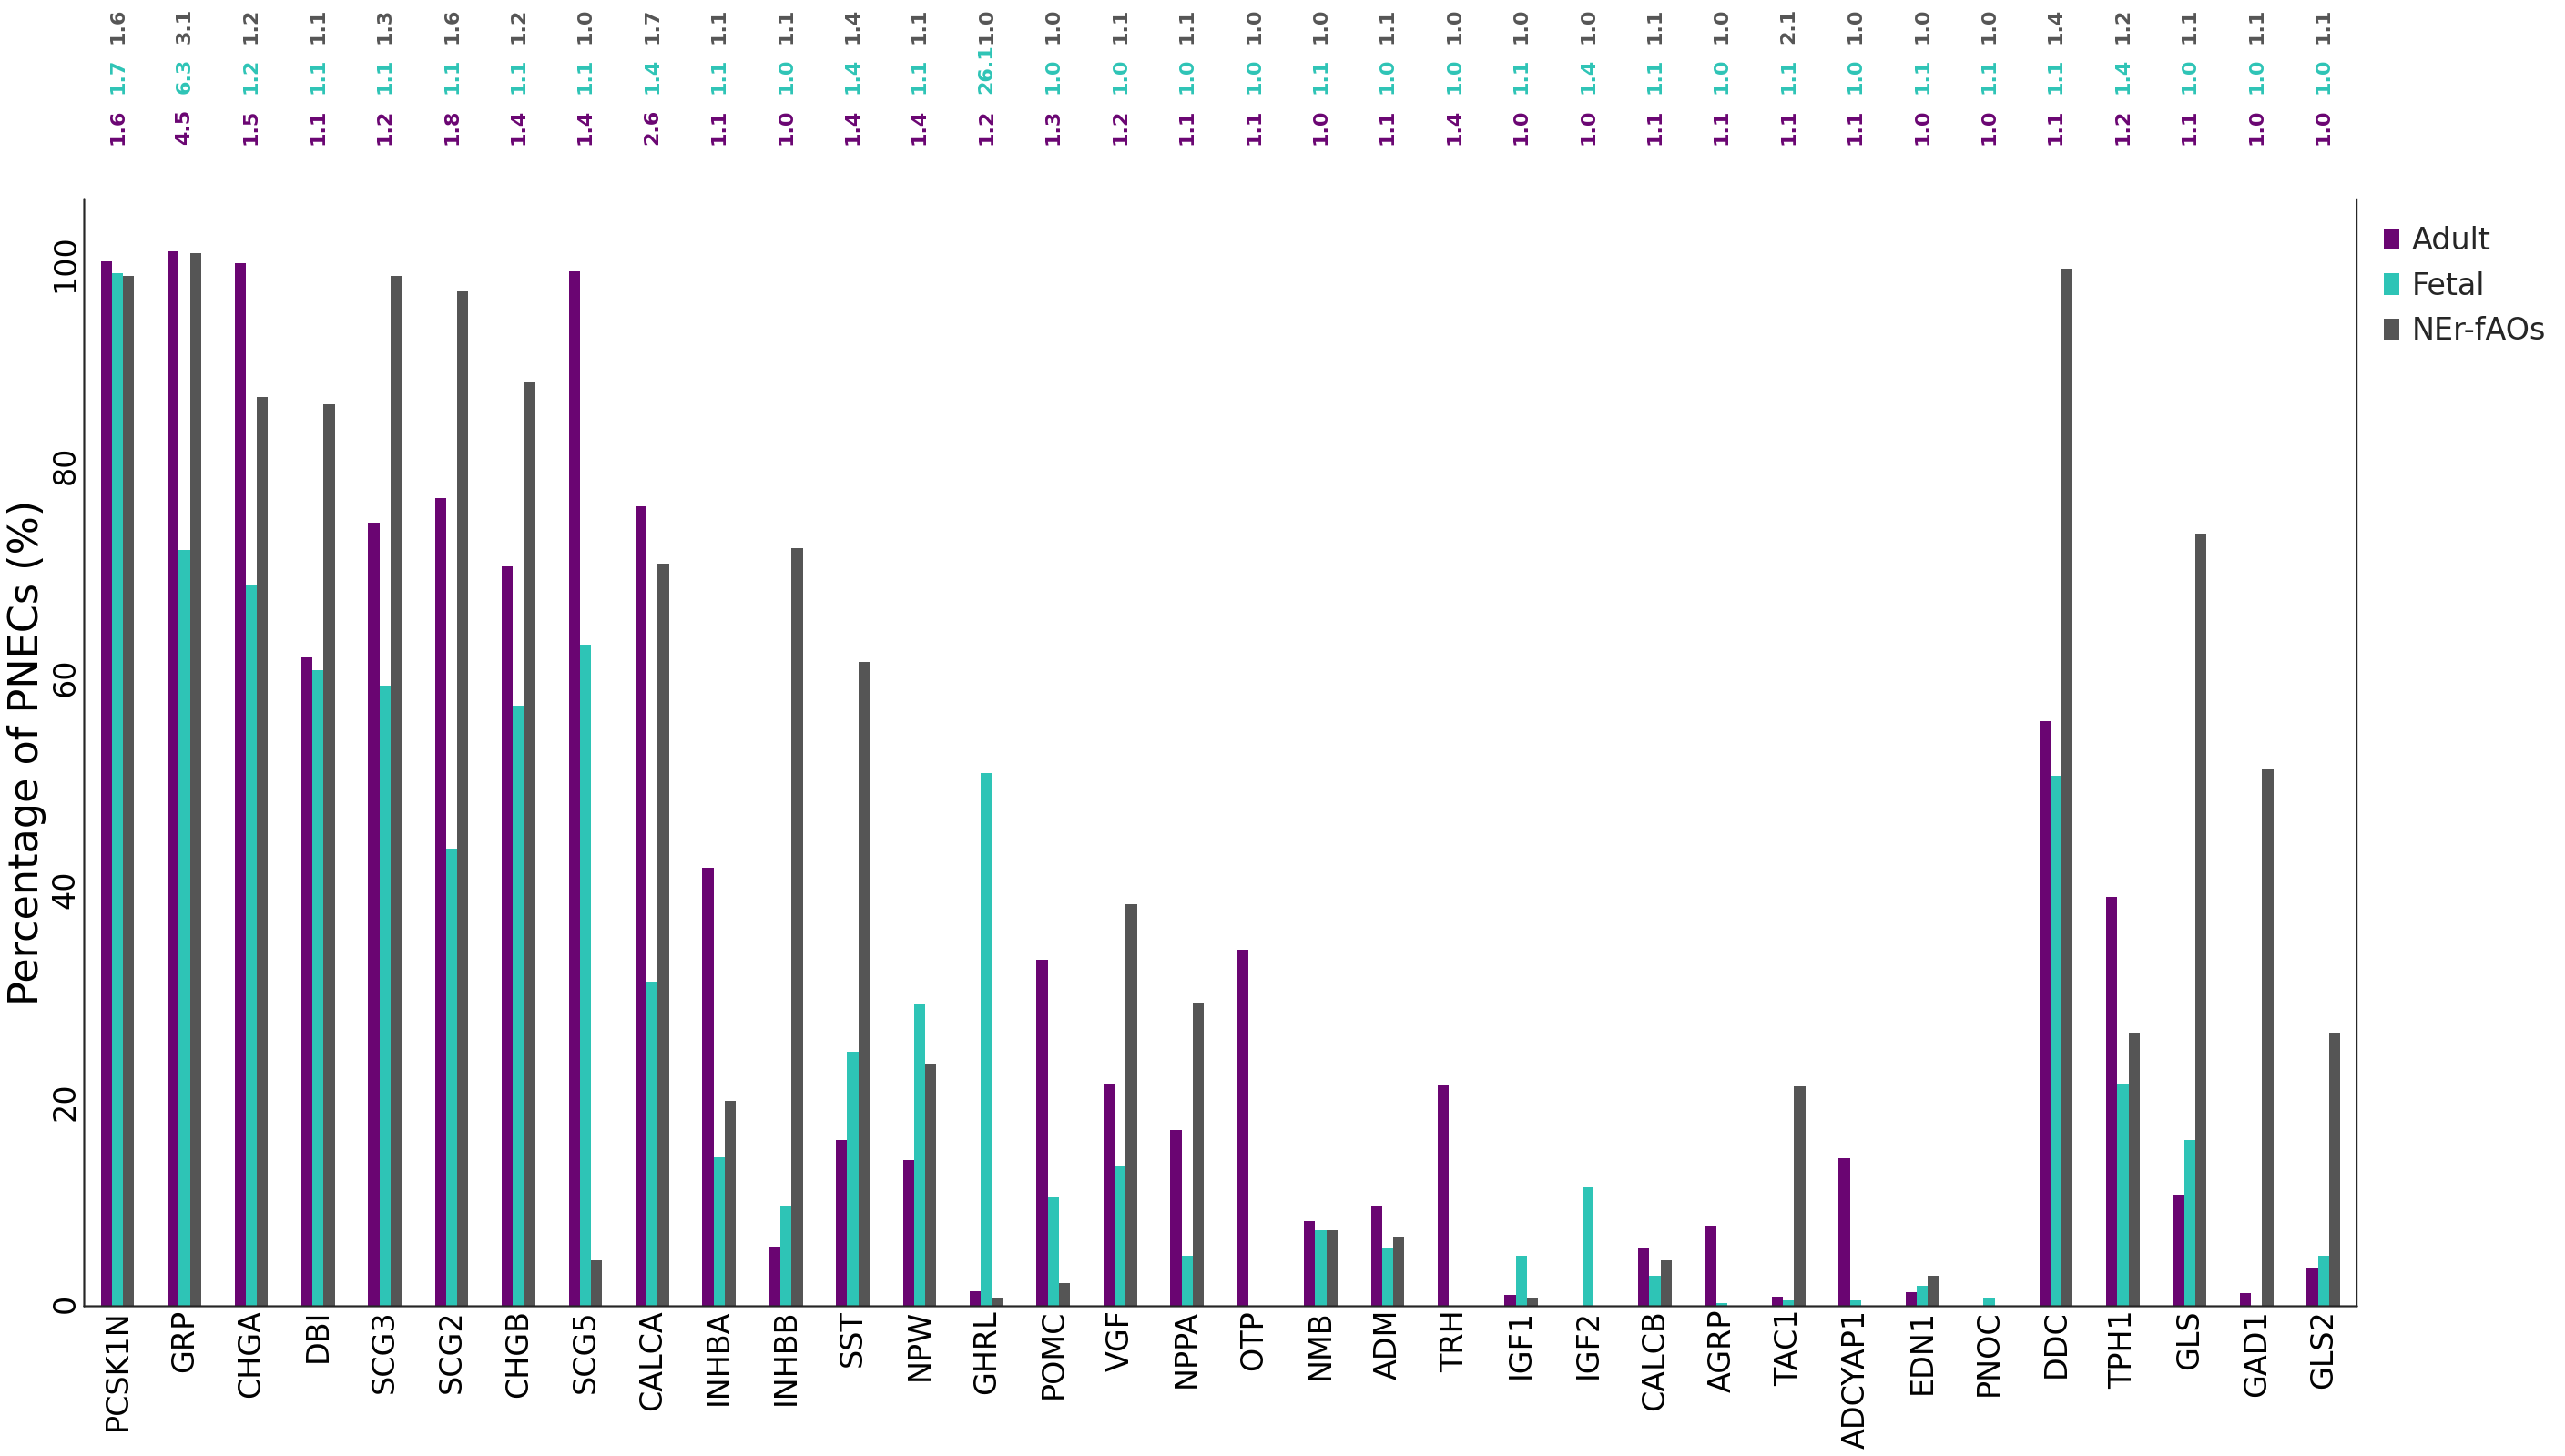

In [27]:
# Set the figure size and style based on your preference
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(40, 20))

# Use the bar function to create a stacked bar plot
genes=[
    #Peptidergic
       'PCSK1N', 'GRP', 'CHGA', 'DBI', 'SCG3', 'SCG2',  'CHGB', 'SCG5',
       'CALCA', 'INHBA',  'INHBB', 'SST', 'NPW', 'GHRL', 'POMC',
       'VGF', 'NPPA', 'OTP',  'NMB', 'ADM',  'TRH', 'IGF1',
       'IGF2', 'CALCB', 'AGRP', 'TAC1', 'ADCYAP1', 'EDN1', 'PNOC',
    #Neuroetransmitters
    'DDC','TPH1', 'GLS','GAD1','GLS2']

df_NE_perc_filtered = df_NE_perc[df_NE.index.isin(genes)]

df_plot = df_NE_perc_filtered[['Adult','Fetal','NEr-fAOs']]


df_plot.plot(kind='bar', stacked=False, color=['#6A0572','#2EC4B6','#555555'],
             edgecolor=None,width=0.5, ax=ax)

# Customize the plot
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=30)
plt.yticks(size=30,color='black',rotation=90)
plt.xticks(rotation=90, size=30, color='black')
plt.ylabel("Percentage of PNECs (%)", size = 40, color='black')

# Add another axis on top with corresponding ticks and values
ax_adult = ax.twiny()
ax_adult.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_adult.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_adult.spines['top'].set_position(('outward', 50))
ax_adult.set_xticklabels(df_NE_perc_filtered['Counts Adult'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#6A0572')

ax_fetal = ax.twiny()
ax_fetal.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_fetal.set_xticks(ax.get_xticks())  # Set the positions of the ticks
ax_fetal.spines['top'].set_position(('outward', 100))
ax_fetal.set_xticklabels(df_NE_perc_filtered['Counts Fetal'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#2EC4B6')

ax_dayton = ax.twiny()
ax_dayton.set_xlim(ax.get_xlim())  # Set the same x-axis limits as the original axis
ax_dayton.set_xticks(ax.get_xticks()) # Set the positions of the ticks
ax_dayton.spines['top'].set_position(('outward', 150))
ax_dayton.set_xticklabels(df_NE_perc_filtered['Counts NEr-fAOs'].to_list(), fontweight='bold',fontsize=20,rotation=90, color='#555555')
ax_dayton.xaxis.set_label_coords(1.05, 1.05)  # Adjust the label position

ax_lee.set_xlabel("Gene Expression\n(Mean CPM+1)", size=30, color='black')
ax_lee.xaxis.set_label_coords(1.05, 1.15)  # Adjust the label position

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax_adult.spines['top'].set_visible(False)
ax_fetal.spines['top'].set_visible(False)
ax_dayton.spines['top'].set_visible(False)
ax_lee.spines['top'].set_visible(False)
ax_adult.spines['right'].set_visible(False)
ax_fetal.spines['right'].set_visible(False)
ax_conchola_organoid.spines['right'].set_visible(False)
ax_lee.spines['right'].set_visible(False)

plt.savefig(os.path.join(figfolder,'BarPlot_Alignment_Neuroendocrine_day10_tissues_NE_genes.pdf'),
            bbox_inches='tight', pad_inches=2)

# Show the plot
plt.show()

In [47]:
NE_genes=[
    #Markers
   'ASCL1', 'UCHL1', 'CHGA', 'GRP', 'CALCA', 'SCGN',  'PCSK1N', 'SCG3', 'SCG5', 'DCC', 'ENO2', 'SYP', 'SV2A', 'SST', 'NCAM1',
    #Peptidergic
       'PCSK1N', 'GRP', 'CHGA', 'DBI', 'SCG3', 'SCG2',  'CHGB', 'SCG5',
       'CALCA', 'INHBA',  'INHBB', 'SST', 'NPW', 'GHRL', 'POMC',
       'VGF', 'NPPA', 'OTP',  'NMB', 'ADM',  'TRH', 'IGF1',
       'IGF2', 'CALCB', 'AGRP', 'TAC1', 'ADCYAP1', 'EDN1', 'PNOC', 'HCRT',
       'AGT', 'CRH', 'INHA',  'GAL',  'NPFF', 'GNRH1', 'CARTPT',
       'NPB', 'PENK', 'EDN3', 'NPPC', 'GNRH2', 'NPY',  'UCN', 'THPO',
        'NPPB', 'IAPP', 'OXT', 'CCK',  'GHRH',
    #Neuroetransmitters
    'DDC','TPH1', 'GLS','GAD1','GLS2','DBH','PNMT','HDC','GAD2','TPH2', 'TH'
]

adata_subset = adata[:, adata.var_names.isin(NE_genes)].copy()
adata_subset

AnnData object with n_obs × n_vars = 2838 × 69
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated_sn

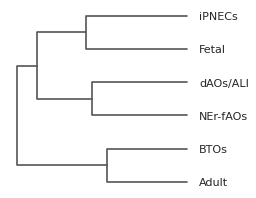

In [48]:
sc.tl.dendrogram(adata_subset,groupby='Tissue',var_names=adata_subset.var_names,use_raw=True,cor_method='spearman',optimal_ordering=True)
plt.figure(figsize=(3, 3))
ax = plt.gca()
sc.pl.dendrogram(adata_subset, groupby='Tissue',ax=ax,orientation='left')
plt.show()

# Neuropeptide Combinations

In [42]:
adata=sc.read_h5ad('./data/Merged_Neuroendocrine_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 2838 × 25813
    obs: 'Sample ID', 'Patient ID', 'Tissue', 'Study', 'Time point', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'Reference', 'Technique', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cloneid', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.3', 'seurat_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype', 'status', 'assignment', 'nCount_SCT', 'nFeature_SCT', 'sample_type', 'scHCL', 'scHCL_summary', 'scHCL_score', 'Age', 'Sex', 'Smoking_status', 'Last_smoking', 'Smoking_amount', 'Comorbidity', 'Specimen_Location', 'Clinical_diagnosis', 'Pathologic_diagnosis', 'integrated

In [43]:
adata.layers['counts'] = adata.layers['counts']
adata.layers['CPM'] = adata.layers['counts']/adata.layers['counts'].sum()*1000000

In [44]:
neuropeptides = [
    #Peptidergic (Neuropeptides)
    'PCSK1N','GRP','CHGA',
    'CALCA', 'CCK', 'SST', 'ADCYAP1', 'ADM', 'AGRP', 'AGT',
    'CALCB', 'CARTPT', 'CHGB', 'CRH', 'DBI', 'EDN1', 'EDN3', 'GAL', 'GHRL', 
    'GNRH1', 'GNRH2', 'HCRT', 'IAPP', 'IGF1', 'IGF2', 'INHA', 'INHBA', 
    'INHBB', 'NMB', 'NPB', 'NPFF', 'NPPA', 'NPPB', 'NPPC', 
    'NPW', 'OXT', 'NPY',  'PNOC', 'POMC', 'SCG2', 
    'SCG3', 'SCG5', 'THPO', 'TRH', 'UCN', 'VGF',
    'TAC1','GHRH','PENK','OTP']
        
# Subset the expression matrix to these genes
adata_subset = adata[:, neuropeptides]

# Create a binary matrix where 1 means the gene is expressed (nonzero count)
expression_binary = (adata_subset.X.toarray() > 0).astype(int)
# Convert to dataframe for easy manipulation
expression_df = pd.DataFrame(expression_binary, index=adata.obs.index, columns=neuropeptides)

# Add tissue information
expression_df["Tissue"] = adata.obs["Tissue"].values

# Group by Tissue and sum across genes (to count how many neuropeptides are expressed per tissue)
neuropeptide_counts = expression_df.groupby("Tissue").sum()

# Count how many neuropeptide genes are expressed in each tissue (at least one cell expresses them)
neuropeptide_presence = (neuropeptide_counts > 0).sum(axis=1)

# Display the result
print(neuropeptide_presence)

Tissue
Adult       50
Fetal       48
NEr-fAOs    46
iPNECs      50
BTOs        48
dAOs/ALI    43
dtype: int64

In [46]:
# Binarize expression (1 = expressed, 0 = not expressed) using a threshold
threshold = 0  # Adjust based on your data
binary_matrix = (adata[:, neuropeptides].layers['counts'].toarray() > threshold).astype(int)

In [47]:
# Convert to DataFrame for easier manipulation
binary_df = pd.DataFrame(binary_matrix, index=adata.obs.index, columns=neuropeptides)

# Create a unique combination label for each cell
adata.obs["neuropeptide_combo"] = binary_df.apply(lambda row: "|".join(row.astype(str)), axis=1)


In [48]:
def label_combinations(row):
    expressed_genes = [gene for gene, expressed in zip(neuropeptides, row) if expressed]
    return "+".join(expressed_genes) if expressed_genes else "None"

In [49]:
adata.obs["neuropeptide_combo_named"] = binary_df.apply(label_combinations, axis=1)


In [50]:
# Check the unique combinations found
unique_combos = adata.obs["neuropeptide_combo_named"].value_counts()
print(unique_combos)

PCSK1N+DBI+IGF2+SCG3                                                  30
PCSK1N+IGF2+SCG3                                                      18
PCSK1N+DBI                                                            16
PCSK1N+CHGB+DBI+IGF2+SCG3                                             16
PCSK1N+DBI+SCG3                                                       15
                                                                      ..
PCSK1N+GRP+CHGA+SST+CHGB+DBI+INHBB+SCG2+SCG3                           1
PCSK1N+GRP+CHGA+SST+CHGB+DBI+INHBA+SCG2+SCG3+TAC1                      1
PCSK1N+GRP+CHGA+CALCA+SST+CHGB+DBI+INHBA+INHBB+NPFF+NPPA+SCG2+SCG3     1
PCSK1N+GRP+CALCA+CHGB+DBI+NMB+SCG2+SCG3                                1
PCSK1N+GRP+CHGA+SCG5+TRH                                               1
Name: neuropeptide_combo_named, Length: 2173, dtype: int64

In [51]:
# This counts how many distinct neuropeptide expression patterns exist per tissue.
combo_counts_per_tissue = adata.obs.groupby("Tissue")["neuropeptide_combo_named"].nunique()
print(combo_counts_per_tissue)

Tissue
Adult       948
Fetal       391
NEr-fAOs    117
iPNECs      517
BTOs        150
dAOs/ALI    100
Name: neuropeptide_combo_named, dtype: int64

In [52]:
cell_counts_per_tissue = adata.obs["Tissue"].value_counts()
normalized_combo_counts = combo_counts_per_tissue / cell_counts_per_tissue
print(normalized_combo_counts)

Adult       0.820779
Fetal       0.926540
NEr-fAOs    0.835714
iPNECs      0.657761
BTOs        0.914634
dAOs/ALI    0.584795
dtype: float64

In [53]:
# Convert the sparse matrix to a dense matrix
adata_dense = adata_subset.X.toarray()

# Sum the number of expressed neuropeptides per PNEC across genes (axis=1)
neuropeptide_counts_per_pnec = (adata_dense > 0).sum(axis=1)

# Flatten to ensure it's a 1D array
neuropeptide_counts_per_pnec = neuropeptide_counts_per_pnec.ravel()

# Check the shape of the result
print(neuropeptide_counts_per_pnec.shape)  # Should print (2200,)

tissue_info = adata_subset.obs["Tissue"].values

# Create the DataFrame
pnec_df = pd.DataFrame({
    "Neuropeptides_Expressed": neuropeptide_counts_per_pnec,
    "Tissue": tissue_info
})

# Display the first few rows of the DataFrame
print(pnec_df.head())

(2838,)

Neuropeptides_Expressed  Tissue
0                        4  iPNECs
1                        5  iPNECs
2                       11  iPNECs
3                        5  iPNECs
4                        7  iPNECs

In [57]:
# Convert the sparse matrix to a dense matrix
adata_dense = adata_subset.X.toarray()

# Sum the number of expressed neuropeptides per PNEC across genes (axis=1)
neuropeptide_counts_per_pnec = (adata_dense > 0).sum(axis=1)

# Flatten to ensure it's a 1D array
neuropeptide_counts_per_pnec = neuropeptide_counts_per_pnec.ravel()

# Check the shape of the result
print(neuropeptide_counts_per_pnec.shape)  # Should print (2200,)

tissue_info = adata_subset.obs["Tissue"].values

# Create the DataFrame
pnec_df = pd.DataFrame({
    "Neuropeptides_Expressed": neuropeptide_counts_per_pnec,
    "Tissue": tissue_info
})

# Group by Tissue and calculate statistics
tissue_stats = pnec_df.groupby("Tissue")["Neuropeptides_Expressed"].agg(
    Mean="mean",
    Std_Dev="std",
    Min="min",
    Max="max"
)

# Add a Range column
tissue_stats["Range"] = tissue_stats["Max"] - tissue_stats["Min"]

# Display the result
print(tissue_stats)

(2838,)

Mean   Std_Dev  Min  Max  Range
Tissue                                        
Adult     11.316017  3.166885    3   24     21
Fetal      7.748815  3.500042    0   34     34
NEr-fAOs   9.692857  3.184713    4   19     15
iPNECs     5.726463  4.350882    0   34     34
BTOs      10.268293  5.619966    1   24     23
dAOs/ALI   3.643275  2.815127    0   16     16

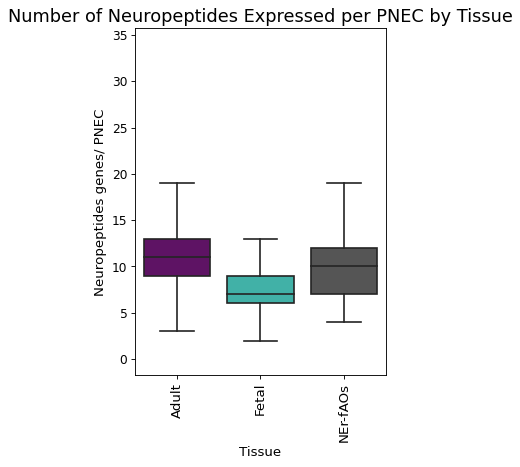

In [54]:
# Create the box plot with scatter points
plt.figure(figsize=(4,6))

# Create the box plot
sns.boxplot(data=pnec_df, x="Tissue", y="Neuropeptides_Expressed", palette=['#6A0572','#2EC4B6','#555555','#FFC300', '#FF5733', '#90EE90'],
            order=['Adult', 'Fetal', 'NEr-fAOs'],
            fliersize=0)

# Customize plot appearance
plt.title("Number of Neuropeptides Expressed per PNEC by Tissue",fontsize=16)
plt.xlabel("Tissue",fontsize=12)
plt.ylabel("Neuropeptides genes/ PNEC", fontsize=12)

# Show the plot
plt.xticks(rotation=90,fontsize=12)  # Rotate x-axis labels for better visibility
plt.tight_layout()

plt.savefig(os.path.join(figfolder, "Alignment_Neuroendocrine_day10_n_neuropeptides_tissue.png"),
                            bbox_inches='tight', pad_inches=0.1)
plt.show()
                

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adult vs. Fetal: t-test independent samples with Bonferroni correction, P_val:8.562e-74 t=1.924e+01
Fetal vs. NEr-fAOs: t-test independent samples with Bonferroni correction, P_val:2.965e-08 t=-5.821e+00
Adult vs. NEr-fAOs: t-test independent samples with Bonferroni correction, P_val:3.880e-08 t=5.724e+00


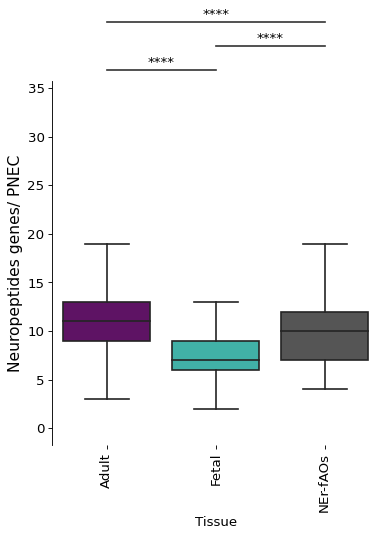

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import os

tissue_order = [
    'Adult', 
    'Fetal', 
    'NEr-fAOs'
]

pairs = [
    ("Adult", "Fetal"),
    ("Adult", "NEr-fAOs"),
    ("Fetal", "NEr-fAOs")
]

plt.figure(figsize=(5,7))
ax = sns.boxplot(
    data=pnec_df, 
    x="Tissue", 
    y="Neuropeptides_Expressed", 
    palette=['#6A0572','#2EC4B6','#555555'],  # only 3 colors needed
    order=tissue_order, 
    fliersize=0
)

# Annotate with statistics
annotator = Annotator(
    ax, pairs, 
    data=pnec_df, 
    x="Tissue", 
    y="Neuropeptides_Expressed", 
    order=tissue_order
)
annotator.configure(
    test='t-test_ind',
    text_format='star',
    loc='outside',
    comparisons_correction='bonferroni',
    line_height=0,            
    line_offset_to_group=0,   
    fontsize=12
)
annotator.apply_and_annotate()

# Hide all spines except the left y-axis spine
for spine in ax.spines:
    if spine == 'left':
        ax.spines[spine].set_visible(True)
    else:
        ax.spines[spine].set_visible(False)

plt.ylabel("Neuropeptides genes/ PNEC", fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel("Tissue", fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()

plt.savefig(
    os.path.join(figfolder, "Alignment_Neuroendocrine_n_neuropeptides_tissue_with_stats"),
    bbox_inches='tight', pad_inches=0.1
)
plt.show()

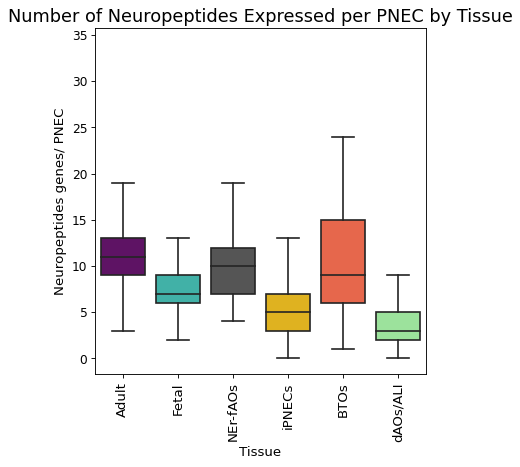

In [56]:
# Create the box plot with scatter points
plt.figure(figsize=(5, 6))

# Create the box plot
sns.boxplot(data=pnec_df, x="Tissue", y="Neuropeptides_Expressed", palette=['#6A0572','#2EC4B6','#555555','#FFC300', '#FF5733', '#90EE90'],
            fliersize=0)

# Customize plot appearance
plt.title("Number of Neuropeptides Expressed per PNEC by Tissue",fontsize=16)
plt.xlabel("Tissue",fontsize=12)
plt.ylabel("Neuropeptides genes/ PNEC",fontsize=12)

# Show the plot
plt.xticks(rotation=90,fontsize=12)  # Rotate x-axis labels for better visibility
plt.tight_layout()

plt.savefig(os.path.join(figfolder, "Alignment_Neuroendocrine_day10_n_neuropeptides_models.png"),
                            bbox_inches='tight', pad_inches=0.1)
plt.show()
                

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adult vs. Fetal: t-test independent samples with Bonferroni correction, P_val:2.569e-73 t=1.924e+01
Fetal vs. NEr-fAOs: t-test independent samples with Bonferroni correction, P_val:8.895e-08 t=-5.821e+00
Adult vs. NEr-fAOs: t-test independent samples with Bonferroni correction, P_val:1.164e-07 t=5.724e+00
Fetal vs. iPNECs: t-test independent samples with Bonferroni correction, P_val:4.490e-15 t=8.225e+00
Adult vs. iPNECs: t-test independent samples with Bonferroni correction, P_val:1.406e-186 t=3.274e+01
Fetal vs. BTOs: t-test independent samples with Bonferroni correction, P_val:1.388e-09 t=-6.518e+00
Adult vs. BTOs: t-test independent samples with Bonferroni correction, P_val:3.962e-03 t=3.524e+00
Fetal vs. dAOs/ALI: t-test independent samples with Bonferroni correction, P_val:4.006e-36 t=1.365e

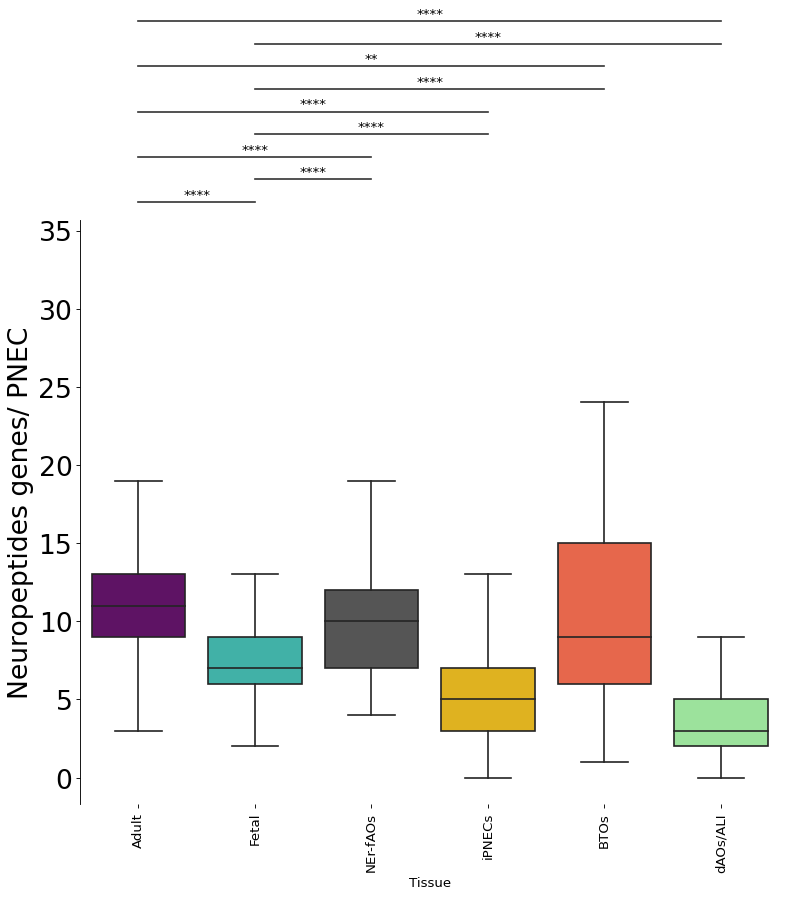

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import os

# Order and filtered pairs
tissue_order = [
    'Adult', 
    'Fetal', 
    'NEr-fAOs', 
    'iPNECs', 
    'BTOs', 
    'dAOs/ALI'
]

pairs = [
    ("Adult", "Fetal"),
    ("Adult", "NEr-fAOs"),
    ("Adult", "iPNECs"),
    ("Adult", "BTOs"),
    ("Adult", "dAOs/ALI"),
    ("Fetal", "NEr-fAOs"),
    ("Fetal", "iPNECs"),
    ("Fetal", "BTOs"),
    ("Fetal", "dAOs/ALI")
]

plt.figure(figsize=(10,12))
ax = sns.boxplot(data=pnec_df, x="Tissue", y="Neuropeptides_Expressed", 
                 palette=['#6A0572','#2EC4B6','#555555','#FFC300', '#FF5733', '#90EE90'],
                 order=tissue_order, fliersize=0)

# Annotate only selected comparisons
annotator = Annotator(ax, pairs, data=pnec_df, x="Tissue", y="Neuropeptides_Expressed", order=tissue_order)
annotator.configure(
    test='t-test_ind',
    text_format='star',
    loc='outside',
    comparisons_correction='bonferroni',
    line_height=0,            
    line_offset_to_group=0,   
    fontsize=12
)
annotator.apply_and_annotate()

# Hide all spines except the left y-axis spine
for spine in ax.spines:
    if spine == 'left':
        ax.spines[spine].set_visible(True)
    else:
        ax.spines[spine].set_visible(False)

plt.ylabel("Neuropeptides genes/ PNEC", fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Tissue", fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()

plt.savefig(os.path.join(figfolder, "Alignment_Neuroendocrine_n_neuropeptides_models_with_stats"),
            bbox_inches='tight', pad_inches=0.1)
plt.show()
